# DeepDream and Image Processing Experiments

*[CV2 STUFF](#cv2stuff) &nbsp;&nbsp;&nbsp; *[Making Thumbnails](#thumbnail) &nbsp;&nbsp;&nbsp; *[Blending Images](#blending) 

%%bash
pip uninstall PIL

#Warning:

no support “import Image”<br />
use “from PIL import Image” instead<br />
no support “import _imaging”<br />
use “from PIL.Image import core as _imaging”<br />
<br />
im = Image.open("lena.ppm")<br />
### Used to display the images as the neural runs over iterations
from IPython.display import clear_output, Image, display<br />
### Used to save and display the image in the IPython notebook as its generated, used only in showarray()
from cStringIO import StringIO<br />
# IPython helper used to show images in progress
def showarray(a, fmt='jpeg'):
<br /><br />
    
#a = np.uint8(np.clip(a, 0, 255))<br />
    a = np.uint8(np.clip(a, 0, 255))<br />
# Convert and clip our matrix into the jpeg constraints (0-255 values for Red, Green, Blue)<br />
        
    f = StringIO()  <br />                    
# Our string file handler<br />
    
    PIL.Image.fromarray(a).save(f, fmt) <br />
# Rather than saving to a file each time, save to our string handler<br />
    
    display(Image(data=f.getvalue())) <br />  
# Display the image in our notebook, using the IPython.display, and IPython.Image helpers.<br />



In [1]:
import os
print os.getcwd()
# An aid to find locate directory and directory structure

/home/jack/deep-dream-generator/notebooks


In [1]:
from cStringIO import StringIO
# Used to save and display the image in the IPython notebook as its generated, used only in showarray()

import numpy as np
# Used to do all the matrix math, with the exception of the zoom

import scipy.ndimage as nd
# Used to do just the zoom on the images, as we go up the sizes (octaves)

import PIL.Image
# Used to load images from file, and to save manipulated images back to files

from IPython.display import clear_output, Image, display
# Used to display the images as the neural runs over iterations

from google.protobuf import text_format
#Inter language data format for our blobs. A way to save and load trained networks in Caffe. Only used to add our *.caffe

import caffe
#The machine learning framework upon which everything works.

#caffe.set_mode_gpu()
# Uncomment above to put computation on GPU. You'll need caffe built with CuDNN and CUDA, and an NVIDIA card

def showarray(a, fmt='jpeg'):
# IPython helper used to show images in progress
    
    #a = np.uint8(np.clip(a, 0, 255))
    a = np.uint8(np.clip(a, 0, 255))
# Convert and clip our matrix into the jpeg constraints (0-255 values for Red, Green, Blue)
        
    f = StringIO()                      
    # Our string file handler
    
    PIL.Image.fromarray(a).save(f, fmt) 
    # Rather than saving to a file each time, save to our string handler
    
    display(Image(data=f.getvalue()))   
    # Display the image in our notebook, using the IPython.display, and IPython.Image helpers.

In [2]:
#model_path = '/notebooks/googlenet_places205/' # substitute your path here
#net_fn   = model_path + 'deploy_places205.protxt'
#param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'

#model_path = '/notebooks/GoogleNet_SOD/' # substitute your path here
#net_fn   = model_path + 'deploy_SOD.prototxt'
#param_fn = model_path + 'GoogleNet_SOD_finetune.caffemodel'

#model_path = '/notebooks/VGG16_SOD/' # substitute your path here
#net_fn   = model_path + 'deploy_VGGsod.prototxt'
#param_fn = model_path + 'VGG16_SOD_finetune.caffemodel'
#VGG_SOD
#conv1_1, conv1_2, pool1, conv2_1, conv2_2, pool2, conv3_1, conv3_2, conv3_3
#pool3, conv4_1, conv4_2, conv4_3, pool4, conv5_1, conv5_2, conv5_3, pool5

#model_path = '/notebooks/hybridCNN/' # substitute your path here
#net_fn   = model_path + 'hybridCNN_deploy_upgraded.prototxt'
#param_fn = model_path + 'hybridCNN_iter_700000_upgraded.caffemodel'
# conv1, pool1, conv2, pool2, conv3, conv4, conv5, pool5

model_path = 'models/googlenet_places365/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'googlenet_places365.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
# In other words, we've included text_format from google.protobuf above just so that we can
# add this single line to the file. If you manually add the line to the prototxt, (or in this
# case, the misspelled protxt (model_path + 'deploy_places205.protxt')included in MIT's set, 
# you'll be able to get rid of the dependency on protobuf.

model = caffe.io.caffe_pb2.NetParameter()           # Load the empty protobuf model,
text_format.Merge(open(net_fn).read(), model)       # Load the prototxt and load it into empty model
model.force_backward = True                         # Add the force_backward: true line
open('tmp.prototxt', 'w').write(str(model))         # Save it to a new file called tmp.prototxt

net = caffe.Classifier('tmp.prototxt', param_fn,    # Load the neural network. Using the prototxt from above
                      #mean = np.float32([104.0, 116.0, 122.0]), # Original ImageNet mean, training set dependent
                       mean = np.float32([104.0, 117.0, 123.0]), # googlenet_places365 mean, training set dependent
                      #mean = np.float32([103.939, 116.779, 123.68]),  #GoogleNet_SOD [103.939, 116.779, 123.68]
                      #mean = np.float32([105.0, 112.0, 124.0]),  #GoogleNet_SOD [103.939, 116.779, 123.68]
                       channel_swap = (2,1,0))      # the reference model has channels in BGR order instead of RGB

# The above code loads up our neural network, but there a few interesting things to note. 
# -> param_fn - our trained neural network blob
# -> mean - the RGB average of our images. we will later subtract and then add this back to our model.
#           interesting changes can be made by changing these numbers, and for the places dataset, the
#           numbers above are actually wrong. I couldn't find the proper mean for it.
# -> channel_swap - different order of values, with Blue, Green and Red as the matrix order. switches it
#                   to Red, Green, Blue
# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

# Now this function above is a doozie. Don't let its shortness deceive you, it's doing a lot.
# net.transformer.mean['data'] is our image mean we discussed above. it's being subtracted from
# np.float32(np.rollaxis(img, 2)[::-1]). This function warrants a discussion about numpy. I'll 
# dive deeper into it below.

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

# This function does the reverse of preprocess, and I'll go over how it works below too. But 
# both these functions warrant talking about how they work.

def preprocesswithoutmean(img):
    return np.float32(np.rollaxis(img, 2)[::-1])

def deprocesswithoutmean(img):
    return np.dstack(img[::-1])



In [3]:
def objective_L2(dst):          # Our training objective. Google has since release a way to load
    dst.diff[:] = dst.data      # arbitrary objectives from other images. We'll go into this later.

def make_step(net, step_size=1.5, end='inception_5a/output',      # Changed this to match my dataset (places)
             #jitter=32, clip=True, objective=objective_L2):
              jitter=10, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''


    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]    # destination is the end layer specified above

    ox, oy = np.random.randint(-jitter, jitter+1, 2)            # generate random jitter
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
                                                                # we'll address the jitter below
            
    net.forward(end=end)     # This is how the network computes, make sure we stop on the chosen neural layer
    objective(dst)           # specify the optimization objective
    net.backward(start=end)  # Do backwards propagation, so we can compute how off we were 
    g = src.diff[0]
    
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g # get closer to our target data

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image jitter
            
    if clip:                                              # If clipping is enabled
        bias = net.transformer.mean['data']               # Subtract our image mean
        src.data[:] = np.clip(src.data, -bias, 255-bias)  # clip our matrix to the values

In [4]:
def deepdream(net, base_img, iter_n=5, octave_n=5, octave_scale=1.4, 
              end='inception_5a/output', clip=True, **step_params):
# prepare base images for all octaves
    octaves = [preprocess(net, base_img)]   
# So, the octaves is an array of images, initialized with the original image transformed into caffe's format
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
# Okay, so this creates smaller versions of the images, and appends them to the array of images. One image for each octave.
    
    src = net.blobs['data']             # Again, copy the original image.
    detail = np.zeros_like(octaves[-1]) # Allocate image for network-produced details.
                                        # This creates a matrix shaped like our image, but fills it with zeroes.

    for octave, octave_base in enumerate(octaves[::-1]): # Iterate over the reversed list of images (smallest first)
        h, w = octave_base.shape[-2:]                    # Take the width and height of the current image
        if octave > 0:  # If it's not the smallest octave upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1) # Zoom in on the image detail, interpolate

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail # Add the changed details to the image
        for i in xrange(iter_n):  # number of step iterations, specified above
            make_step(net, end=end, clip=clip, **step_params) # call the function that actually runs the network
            
            # visualization
            vis = deprocess(net, src.data[0]) # Convert back to jpg format
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True) # clear previous input
              
        detail = src.data[0]-octave_base   # extract details produced on the current octave
    
    return deprocess(net, src.data[0]) # returning the resulting image

# TRANSPARENT IMAGE Invisable image ( transparent image ) below

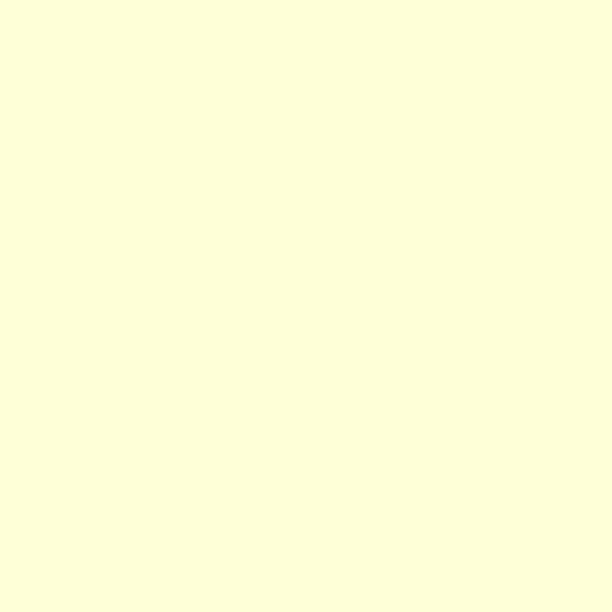

In [5]:
from cStringIO import StringIO
from PIL import Image
import numpy as np
def showarray(a, fmt='jpeg'):
# IPython helper used to show images in progress
    
    #a = np.uint8(np.clip(a, 0, 255))
    a = np.uint8(np.clip(a, 0, 255))
# Convert and clip our matrix into the jpeg constraints (0-255 values for Red, Green, Blue)
        
    f = StringIO()                      
    # Our string file handler
    
    PIL.Image.fromarray(a).save(f, fmt) 
    # Rather than saving to a file each time, save to our string handler
    
    display(Image(data=f.getvalue()))   
    # Display the image in our notebook, using the IPython.display, and IPython.Image helpers.
basewidth = 150

inlay1 = Image.open("images/0035.png")
inlay1.save('images/gray_con.png')
inlay2 = Image.open("images/0045.png")
inlay2.convert('RGBA')
inlay2.save('images/gray_conrgb.png')
#inlay2 = Image.newinlay2 = Image.new('RGBA', (612, 612), (255, 255, 255, 125))('RGBA', (612, 612), (255, 255, 255, 125))
inlay2 = Image.new('RGBA', (612, 612), (255, 255, 215, 0))
inlay2.save('images/gray_conrgbtran.png')
from IPython.display import clear_output, Image, display
import PIL.Image    
pngs = np.float32(PIL.Image.open('images/gray_conrgbtran.png'))   
showarray(pngs)

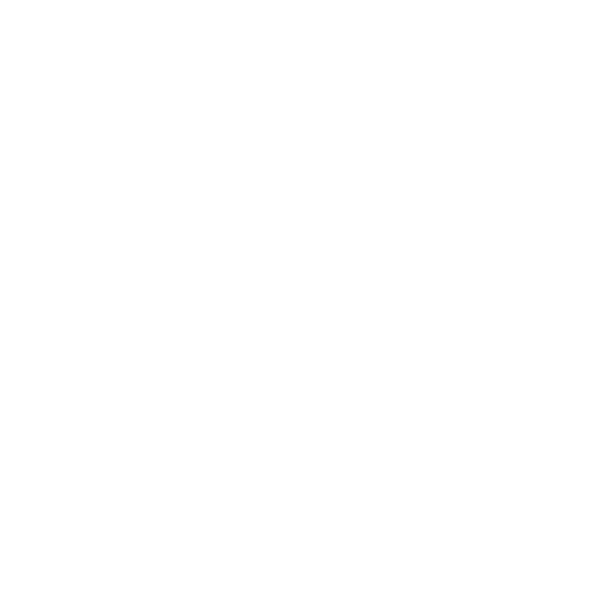

In [28]:
from PIL import Image, ImageDraw
inlay2 = Image.new('RGBA', (612, 612), (255, 255, 255, 0))
inlay2.save('images/gray_conrgbtran.png')
from IPython.display import clear_output, Image, display
pngs = np.float32(PIL.Image.open('images/gray_conrgbtran.png'))   
showarray(pngs)

In [16]:
from PIL import Image
overlay = Image.open('images/0014.png').convert("RGBA") 
overlay.load()
overlay.split()
base = Image.open('images/0039.png').convert("RGBA")
base.load()
base.split()
"""
card = Image.new("RGBA", (220, 220), (255, 255, 255))
img = Image.open("images/test.png").convert("RGBA")
x, y = img.size
card.paste(img, (0, 0, x, y), img)
card.save("images/test.png", format="png")
"""

bands = list(overlay.split())
if len(bands) == 4:
    # Assuming alpha is the last band
    bands[3] = bands[3].point(lambda x: x*0.4)
overlay = Image.merge(overlay.mode, bands)

base.paste(overlay, (0, 0), overlay)
base.save('images/result.png')


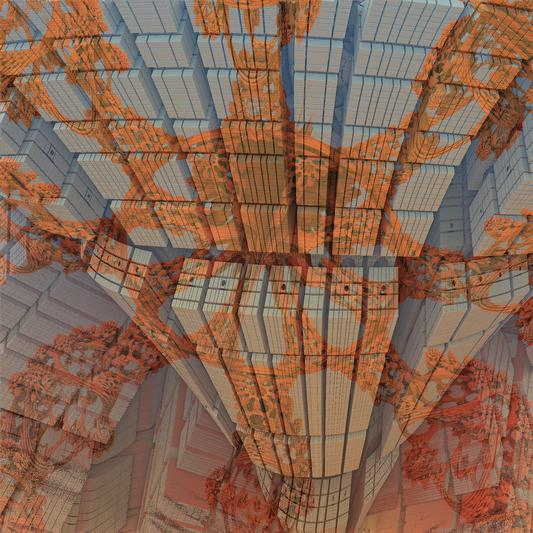

In [13]:
from IPython.display import clear_output, Image, display
imz = np.float32(PIL.Image.open('images/result.png'))   
showarray(imz)

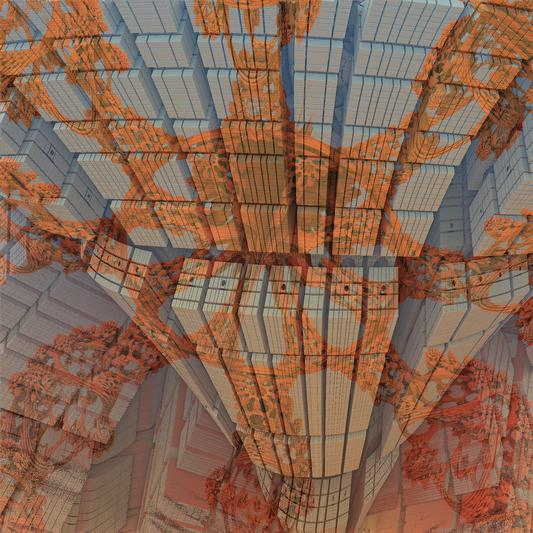

In [18]:
from IPython.display import clear_output, Image, display
imz = np.float32(PIL.Image.open('images/result.png'))   
showarray(imz)

In [22]:
def p(self, b=None):
    if b is None:
        b = self.a
    print (b)

In [24]:
from PIL import Image
overlay = Image.open('images/0040.png')
base = Image.open('images/0045.png')

bands = list(overlay.split())
if len(bands) == 4:
    # Assuming alpha is the last band
    bands[3] = bands[3].point(lambda x: x*0.4)
overlay = Image.merge(overlay.mode, bands)

base.paste(overlay, (0, 0), overlay)
base.save('images/result3.png')

ValueError: bad transparency mask

In [30]:
from IPython.display import clear_output, Image, display
from PIL import Image, ImageDraw
overlay = Image.open('images/0040.png')
image=Image.open("images/result.png")
opacity=0.5
bands=list(overlay.image.split())
if len(bands)==4:
    bands[3]=bands[3].point(lambda x:x*opacity)
    new_image=Image.merge(image.mode,bands)
    
import cv2
cv2.imwrite('dream1.png', new_image)      

AttributeError: 'PngImageFile' object has no attribute 'image'

In [31]:
from cStringIO import StringIO
#import Image
from PIL import Image
import datetime
import numpy as np 
i = 0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()  
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


for i in xrange(10): 
    background = Image.open("a.png")
    foreground = Image.open("mask_color.png")
    import Image
    background.paste(foreground, (30, 30, foreground)
    background.save("abc.png")
    #filename = datetime.datetime.now().strftime("/notebooks/%M:%S.png")
    filename = datetime.datetime.now().strftime("images/%d_%m_%Y_%H:%M:%S.png")
    PIL.Image.fromarray(np.uint8(background)).save(filename)  
    
from IPython.display import clear_output, Image, display
merge = np.float32(PIL.Image.open("abc.png"))   
showarray(merge)   

SyntaxError: invalid syntax (<ipython-input-31-883a293e4760>, line 26)

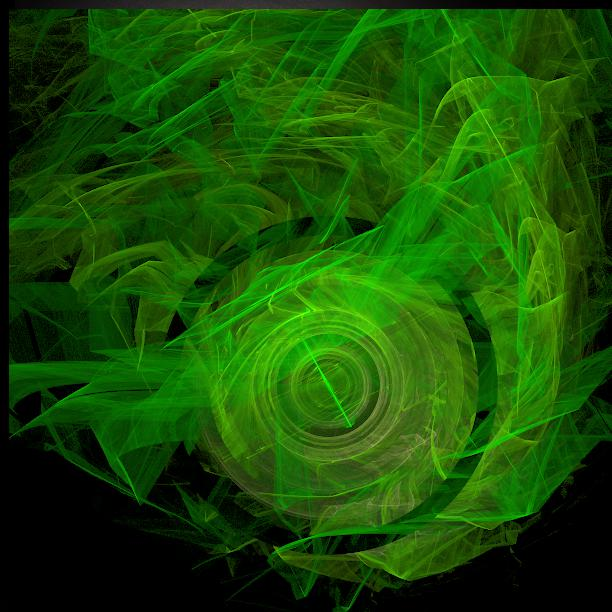

In [35]:
from PIL import Image
import time
import numpy as np
mv = 0
for i in xrange(10): 
    background = Image.open("images/0055.png")
    foreground = Image.open("images/0043.png")

    background.paste(foreground, (1*mv, 1*mv), foreground)
    background.save("images/abc.png")
    mv = mv + 1
    #time.sleep(2)
    #filename = datetime.datetime.now().strftime("/notebooks/%d_%m_%Y_%H:%M:%S.jpg")
    filename = ("images/new_%004d.jpg"%mv)
    
    PIL.Image.fromarray(np.uint8(background)).save(filename)  
    
from IPython.display import clear_output, Image, display
merge = np.float32(PIL.Image.open("images/abc.png"))   
showarray(merge)   

In [36]:
#("junk4/%04d.jpg"%frame_i)
def vidfiles(backgrounda, h, v, foregounda, *args):
    for i in xrange(10): 
        from PIL import Image
        background = Image.open("images/0027.png")
        foreground = Image.open("images/0029.png")
        background.paste(background, h, v, foreground)
        #background.save("mov_%04.png"%movt)
        background.save("mov_%04.png")  
      
        return ()
       
    
    


In [37]:
def vidfiles( *args, **kwargs):
    saved_args = locals()
    print("saved_args is", saved_args)
    local_var = 10
    print("saved_args is", saved_args)
    print("But locals() is now", locals())

In [38]:
vidfiles("a.png", 30, 30, "maskcolor.png") 

('saved_args is', {'args': ('a.png', 30, 30, 'maskcolor.png'), 'kwargs': {}})
('saved_args is', {'args': ('a.png', 30, 30, 'maskcolor.png'), 'kwargs': {}})
('But locals() is now', {'saved_args': {...}, 'args': ('a.png', 30, 30, 'maskcolor.png'), 'local_var': 10, 'kwargs': {}})


In [43]:
#("junk4/%04d.jpg"%frame_i)
def vidfiles(background1, foregound2, output):
    mov = 0    
    for i in xrange(10): 
        
        from PIL import Image
        background = Image.open(background1)
        foreground = Image.open(foregound2)
        background.paste(foreground, (mov, mov), foreground)
        background.save("%04",output,".png"%mov)
        mov = mov +1  
    return ()
       
    
    
vidfiles("images/0037.png", "images/0038.png", "images/aAndb.png") 

ValueError: bad transparency mask

In [68]:
#Good Overlay April-23
#do not touch working fine
from PIL import Image
inlay = Image.open("images_tmp/1000.jpg")
inlay.save('images_tmp/cp_orig.jpg')
imgo = Image.open('images_tmp/cp_orig.jpg')
for i in xrange(10):
    basewidth = 60*i
    wpercent = (basewidth / float(imgo.size[0]))
    hsize = int((float(imgo.size[1]) * float(wpercent)))
import PIL.Image
inlay2 = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img_w, img_h = inlay2.size
inlay2.save('images_tmp/sized.jpg')
background = Image.open('images_tmp/paste_exp.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(inlay2, offset)
background.save('images_tmp/paste_exp.jpg')
#do not touch working fine


In [69]:
#exp  #exp  #exp  #exp  #exp  #exp  #exp  #exp
import PIL.Image
def functionshrink(inlay, var, background):    
    from PIL import Image
    inlay.save('images_tmp/cp_orig.jpg')
    imgo = Image.open('images_tmp/cp_orig.jpg')
    for i in xrange(10):
        basewidth = 100*var
        wpercent = (basewidth / float(imgo.size[0]))
        hsize = int((float(imgo.size[1]) * float(wpercent)))
        inlay2 = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
        img_w, img_h = inlay2.size
        inlay2.save('images_tmp/sized.jpg')
          
        bg_w, bg_h = background.size
        offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
        background.paste(inlay2, offset)
        background.save('images_tmp/paste_exp.jpg')
    return (background, inlay2) 
#do not touch working fine
#functionshrink(Image.open("/notebooks/APR22/inlay/1000.jpg"), 2, Image.open('/notebooks/APR22/inlay/paste_exp.jpg')) 

In [64]:
functionshrink("images/0083.png", 1, 'images/0084.png')

AttributeError: 'str' object has no attribute 'save'

In [52]:


functionshrink(Image.open("/notebooks/APR22/inlay/1000.jpg"), 1, Image.open('/notebooks/APR22/inlay/paste_exp.jpg'))

AttributeError: type object 'Image' has no attribute 'open'

#   START START START START START START START START START START

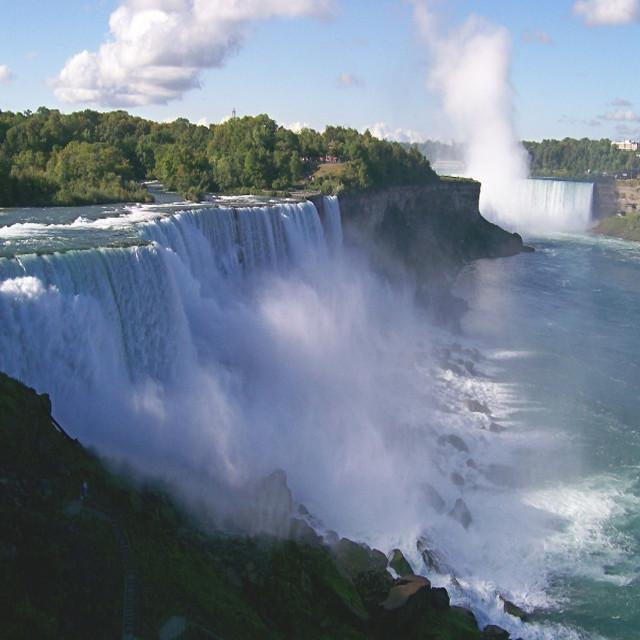

In [54]:
from IPython.display import clear_output, Image, display
eezi = np.float32(PIL.Image.open('images/25.jpg'))   
showarray(eezi)

In [70]:
def functionshrink(inlayo, inlays, var, backgroundo): 
     import PIL.Image    
     from PIL import Image
     inlay = Image.open(inlayo)   
     inlay.save(inlays)
     imgo = Image.open('images_tmp/cp_orig.jpg')
     for i in xrange(10):
          basewidth = 50*var
          wpercent = (basewidth / float(imgo.size[0]))
          hsize = int((float(imgo.size[1]) * float(wpercent)))
          inlay2 = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
          img_w, img_h = inlay2.size
          inlay2.save('images_tmp/sized.jpg')
          background = Image.open(backgroundo)
          background.save('images_tmp/background_work.jpg')
          background = Image.open('images_tmp/background_work.jpg')  
          bg_w, bg_h = background.size
          offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
          background.paste(inlay2, offset)
          background.save('images_tmp/paste_exp11.jpg')
     return (background, inlay2) 
#do not touch working fine
#functionshrink("/notebooks/APR22/inlay/1000.jpg", "/notebooks/APR22/inlay/cp_orig.jpg", 2,"/notebooks/APR22/inlay/paste_exp.jpg") 

In [71]:
functionshrink("images/0046.jpg", \
               "images/0039.jpg", \
               2,"images/0058.jpg") 

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x612 at 0x7FA7D9DF3F90>,
 <PIL.Image.Image image mode=RGB size=100x66 at 0x7FA7D9D26C10>)

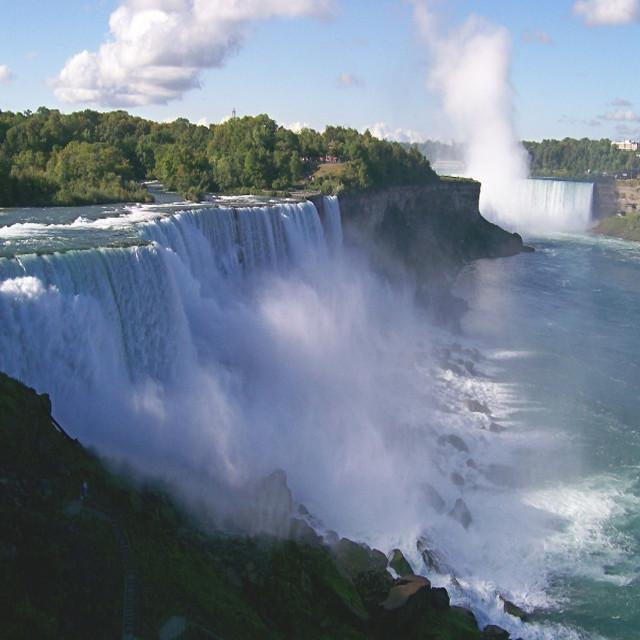

In [72]:
from IPython.display import clear_output, Image, display
merge = np.float32(PIL.Image.open("images/25.jpg"))   
showarray(merge)   

In [87]:
#exp  #exp  #exp  #exp  #exp  #exp  #exp  #exp

def functionshrink(inlayo, inlays, var, background): 
    import PIL.Image    
    from PIL import Image
    inlay = Image.open(inlayo)   
    inlay.save(inlays, "JPG")
    imgo = Image.open('images_n/cp_orig.jpg')
    for i in xrange(10):
        basewidth = 100*var
        wpercent = (basewidth / float(imgo.size[0]))
        hsize = int((float(imgo.size[1]) * float(wpercent)))
        inlay2 = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
        img_w, img_h = inlay2.size
        inlay2.save('images_n/sized.jpg', "JPG")
        background = Image.open(background)
        background.save('images_n/background_work.jpg')
        background = Image.open('images_n/background_work.jpg')  
        bg_w, bg_h = background.size
        offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
        background.paste(inlay2, offset)
        background.save('images_n/paste_exp8.jpg')
    return (background, inlay2) 
#do not touch working fine
#functionshrink("/notebooks/APR22/inlay/1000.jpg", "/notebooks/APR22/inlay/cp_orig.jpg", 2,"/notebooks/APR22/inlay/paste_exp.jpg") 

In [88]:
functionshrink("images/0057.jpg", "images/0050jpg", 2, "images/0037.jpg") 

KeyError: 'JPG'

In [ ]:
import PIL
import datetime
#from PIL import Image
from IPython.display import clear_output, Image, display
frame = eezi
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(3):
    from IPython.display import clear_output, Image, display
    imgz = np.float32(PIL.Image.open('/notebooks/APR22/0001.jpg'))       
    #imz = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))
    frame = deepdream(net, imgz)
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filename = datetime.datetime.now().strftime("/notebooks/APR22/inlay/%d_%m_%Y_%H:%M:%S.jpg")
    PIL.Image.fromarray(np.uint8(frame)).save(filename)
 
functionshrink(Image.open("/notebooks/APR22/inlay/1000.jpg"), 1, Image.open('/notebooks/APR22/inlay/paste_exp.jpg'))   
 #function returns  return (background, inlay2)    
  
import shutil
shutil.copy("/notebooks/APR22/inlay/paste_complete.jpg","/notebooks/APR22/0001.jpg")

from IPython.display import clear_output, Image, display  
frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
showarray(frame)
frame_i += 1

img = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))    

## END

In [47]:
import PIL.Image
def functionresize(basewidth):
   wpercent = (basewidth / float(imgo.size[0]))
   hsize = int((float(imgo.size[1]) * float(wpercent)))
   inlay2 = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
   img_w, img_h = inlay2.size 
   inlay2.save('/notebooks/APR22/inlay/400.jpg')
    
return (inlay2, offset)     
from PIL import Image
background = Image.open('/notebooks/a.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)   

#print img_w, img_h, inlay, offset, background
print background

SyntaxError: 'return' outside function (<ipython-input-47-742b5b170cad>, line 9)

In [23]:
#Good Overlay April-23
#work with this
import PIL.Image
from PIL import Image
inlay = Image.open("/notebooks/snakewave.jpg")
inlay.save('/notebooks/APR22/inlay/cp_orig.png')
imgo = Image.open('/notebooks/APR22/inlay/cp_orig.png')
for i in xrange(10):
  functionresize(300)
inlay2 = Image.open("/notebooks/APR22/inlay/400.jpg")
background.paste(inlay2, offset)
background.save('/notebooks/APR22/inlay/paste_exp.jpg')
#work with this
print inlay2, offset, background

NameError: name 'offset' is not defined

In [88]:
from PIL import Image
inlay = Image.open("/notebooks/snakewave.jpg")
background = Image.open('/notebooks/b.jpg')
creatoverlay(inlay, background):




SyntaxError: invalid syntax (<ipython-input-88-03089dac76db>, line 4)

In [ ]:
inlay = Image.open("/notebooks/APR22/inlay/1000.jpg")
background = Image.open('/notebooks/APR22/inlay/paste_exp.jpg')

In [48]:
nimgg = createoverlay(imgprint)
PIL.Image.fromarray(np.uint8(nimgg)).save("/notebooks/APR22/inlay/xxxxxxxx.jpg")

NameError: name 'imgprint' is not defined

In [76]:
import PIL
import datetime
#from PIL import Image
from IPython.display import clear_output, Image, display
frame = eezi
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(3):
    from IPython.display import clear_output, Image, display
    imgz = np.float32(PIL.Image.open('/notebooks/APR22/0001.jpg'))       
    #imz = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))
    frame = deepdream(net, imgz)
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filename = datetime.datetime.now().strftime("/notebooks/APR22/inlay/%d_%m_%Y_%H:%M:%S.jpg")
    PIL.Image.fromarray(np.uint8(frame)).save(filename)
           
from PIL import Image
inlay = Image.open("/notebooks/APR22/inlay/1000.jpg")
inlay.save('/notebooks/APR22/inlay/Foto.png')
imgo = Image.open('/notebooks/APR22/inlay/Foto.png')

basewidth = 150*i
wpercent = (basewidth / float(imgo.size[0]))
hsize = int((float(imgo.size[1]) * float(wpercent)))

inlay = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
inlay = Image.new('RGBA', (basewidth, hsize), (255, 255, 225, 255))
img_w, img_h = inlay.size
inlay.save('/notebooks/APR22/inlay/400.png')

background = Image.open('/notebooks/APR22/0001.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(inlay, offset)
background.save('/notebooks/APR22/inlay/paste_complete.jpg')
#do not touch working fine

import shutil
shutil.copy("/notebooks/APR22/inlay/paste_complete.jpg","/notebooks/APR22/0001.jpg")

from IPython.display import clear_output, Image, display  
frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
showarray(frame)
frame_i += 1

img = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))    

NameError: name 'eezi' is not defined

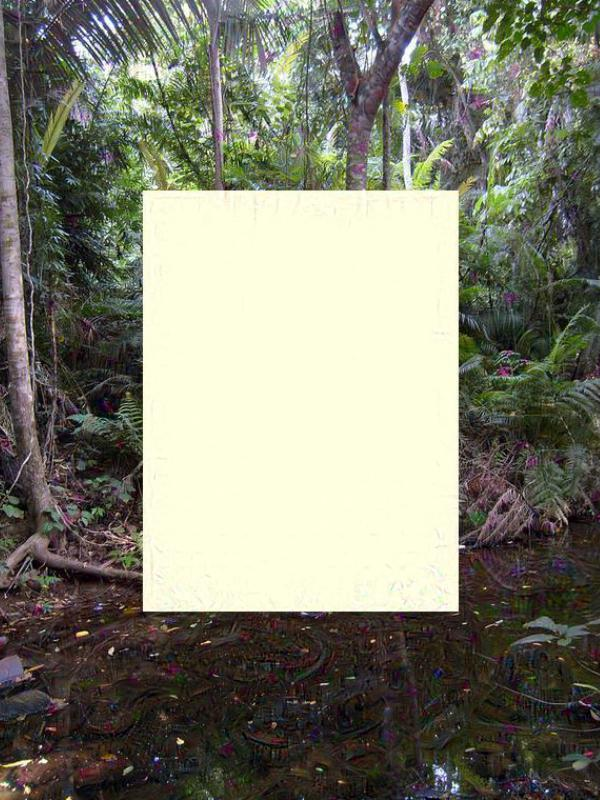

IOError: [Errno 2] No such file or directory: '/notebooks/APR22/inlay/400.jpg'

In [42]:
import PIL
import datetime
#from PIL import Image
from IPython.display import clear_output, Image, display
frame = eezi
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(3):
    from IPython.display import clear_output, Image, display
    imgz = np.float32(PIL.Image.open('/notebooks/APR22/0001.jpg'))       
    #imz = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))
    frame = deepdream(net, imgz)
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filename = datetime.datetime.now().strftime("/notebooks/APR22/inlay/%d_%m_%Y_%H:%M:%S.jpg")
    PIL.Image.fromarray(np.uint8(frame)).save(filename)
    
    
    # datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
   # filename = datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S"), ".jpg"
   # PIL.Image.fromarray(np.uint8(frame)).save(filename)
       
    #11:27 Change :
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    #to
    #PIL.Image.fromarray(np.uint8(frame)).save("/notebooks/APR22/0001.jpg")
        
from PIL import Image
basewidth = 150*i
inlay = Image.open("/notebooks/APR22/inlay/1000.jpg")
inlay.save('/notebooks/APR22/inlay/Foto.png')
imgo = Image.open('/notebooks/APR22/inlay/Foto.png')
wpercent = (basewidth / float(imgo.size[0]))
hsize = int((float(imgo.size[1]) * float(wpercent)))
inlay = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
inlay = Image.new('RGBA', (basewidth, hsize), (255, 255, 225, 255))
img_w, img_h = inlay.size
inlay.save('/notebooks/APR22/inlay/400.png')

background = Image.open('/notebooks/APR22/0001.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(inlay, offset)
background.save('/notebooks/APR22/inlay/paste_complete.jpg')
#do not touch working fine

import shutil
shutil.copy("/notebooks/APR22/inlay/paste_complete.jpg","/notebooks/APR22/0001.jpg")



from IPython.display import clear_output, Image, display  
frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
showarray(frame)
frame_i += 1

img = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))    

In [23]:
filename3 = datetime.datetime.now().strftime("/notebooks/APR22/store/%d_%m_%Y_%H:%M:%S.jpg")
PIL.Image.fromarray(np.uint8(img)).save(filename3)

In [24]:
filename4 = datetime.datetime.now().strftime("/notebooks/APR22/store/cycle.jpg")
PIL.Image.fromarray(np.uint8(img)).save(filename4)

In [25]:
PIL.Image.fromarray(np.uint8(img)).save("newsave/%04d.jpg"%frame_i)

In [ ]:
http://tutorial.simplecv.org/en/latest/examples/basics.html

In [ ]:
!mkdir /notebooks/APR22 
!mkdir /notebooks/APR22/store 
!mkdir /notebooks/APR22/src 
!mkdir /notebooks/APR22/junk2 
!mkdir /notebooks/APR22/inlay
from shutil import copyfile
copyfile('APR22_IMG/400.jpg', '/notebooks/APR22/400.jpg')
copyfile('APR22_IMG/400.jpg', '/notebooks/APR22/inlay/400.jpg')
copyfile('APR22_IMG/400.jpg', '/notebooks/APR22/store/1000.jpg')
copyfile('APR22_IMG/400.jpg', '/notebooks/APR22/src/400.jpg')

In [96]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
filename = datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S.jpg")
print filename

22_04_2017_06:41:57.jpg


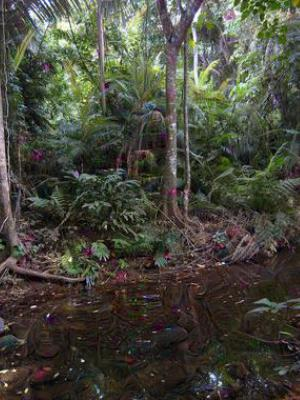

In [32]:
import PIL
import datetime
#from PIL import Image
from IPython.display import clear_output, Image, display
frame = imz
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(3):
    from IPython.display import clear_output, Image, display
    imgz = np.float32(PIL.Image.open('/notebooks/APR22/0001.jpg'))       
    #imz = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))
    frame = deepdream(net, img)
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filename = datetime.datetime.now().strftime("/notebooks/APR22/inlay/%d_%m_%Y_%H:%M:%S.jpg")
    PIL.Image.fromarray(np.uint8(frame)).save(filename)
    
    
    # datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
   # filename = datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S"), ".jpg"
   # PIL.Image.fromarray(np.uint8(frame)).save(filename)
       
    #11:27 Change :
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    #to
    #PIL.Image.fromarray(np.uint8(frame)).save("/notebooks/APR22/0001.jpg")
        
from PIL import Image
basewidth = 150*i
inlay = Image.open("/notebooks/APR22/inlay/1000.jpg")
wpercent = (basewidth / float(inlay.size[0]))
hsize = int((float(inlay.size[1]) * float(wpercent)))
inlay = inlay.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
inlay.save('/notebooks/APR22/inlay/400.jpg')
#img = Image.open('800px-Tioman_Rainforest_.jpg', 'r')
imgo = Image.open('/notebooks/APR22/inlay/400.jpg', 'r')
imgo = Image.new('RGBA', (600, 800), (255, 255, 225, 0))
img_w, img_h = imgo.size
#background = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))
#background = Image.open('/notebooks/APR22/store/1000.jpg')
background = Image.open('/notebooks/APR22/0001.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(imgo, offset)
background.save('/notebooks/APR22/inlay/paste_complete.jpg')
#do not touch working fine

import shutil
shutil.copy("/notebooks/APR22/inlay/paste_complete.jpg","/notebooks/APR22/0001.jpg")



from IPython.display import clear_output, Image, display  
frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
showarray(frame)
frame_i += 1

img = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))    

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print timestr

filename1 = datetime.now().strftime("%Y%m%d-%H%M%S")
sys.stdout = open(timestr + '.jpg', 'w')



import time
date_string = time.strftime("%Y-%m-%d-%H:%M")
cam.saveSnapshot(r'C:\Users\Myname\Dropbox\Foldes\image-' + date_string + '.png',
                 timestamp=3, boldfont=1, textpos='bc')



import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
filename = "/notebook/APR22/store" + datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S") + ".jpg"
PIL.Image.fromarray(np.uint8(frame)).save(filename)

import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
filename = "/notebook/APR22/store" + datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S") + ".jpg"
inlay.save(filename)





In [114]:
import PIL
import datetime
#from PIL import Image
from IPython.display import clear_output, Image, display
frame = imz
frame_i = 0
h, w = frame.shape[:2]
s = 0.01 # scale coefficient
for i in xrange(3):
    from IPython.display import clear_output, Image, display
          #imz = np.float32(PIL.Image.open('/notebooks/APR22/src/400.jpg'))       
    #imz = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))
    frame = deepdream(net, imz)
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filename = datetime.datetime.now().strftime("/notebooks/APR22/inlay/%d_%m_%Y_%H:%M:%S.jpg")
    PIL.Image.fromarray(np.uint8(frame)).save(filename)
    
    
    # datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
   # filename = datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S"), ".jpg"
   # PIL.Image.fromarray(np.uint8(frame)).save(filename)
       
    #11:27 Change :
    #PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    #to
    #PIL.Image.fromarray(np.uint8(frame)).save("/notebooks/APR22/0001.jpg")
        
from PIL import Image
basewidth = 40*frame_i
inlay = Image.open("/notebooks/APR22/inlay/400.jpg")
wpercent = (basewidth / float(inlay.size[0]))
hsize = int((float(inlay.size[1]) * float(wpercent)))
inlay = inlay.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
inlay.save('/notebooks/APR22/inlay/400.jpg')

#datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#filename2 = datetime.datetime.now().strftime("/notebooks/APR22/store/%d_%m_%Y_%H:%M:%S.jpg")
#inlay.save(filename2)    

#datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#filename = "/notebook/APR22/store" + datetime.datetime.now().strftime("%d_%m_%Y_%H:%M:%S") + ".jpg"
#inlay.save(filename)




#do not touch working fine
#from PIL import Image
#img = Image.open('800px-Tioman_Rainforest_.jpg', 'r')
imgo = Image.open('/notebooks/APR22/inlay/400.jpg', 'r')
#imgo = Image.new('RGBA', (600, 800), (255, 255, 225, 255))
img_w, img_h = imgo.size
#background = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))
#background = Image.open('/notebooks/APR22/store/1000.jpg')
background = Image.open('/notebooks/APR22/0001.jpg')



bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(imgo, offset)
background.save('/notebooks/APR22/inlay/400.jpg')
#do not touch working fine
    
from IPython.display import clear_output, Image, display  
frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
showarray(frame)
frame_i += 1

img = np.float32(PIL.Image.open('/notebooks/APR22/inlay/400.jpg'))    

MemoryError: 

In [94]:
from IPython.display import clear_output, Image, display
ims = np.float32(PIL.Image.open('junk/60.jpg'))   
showarray(ims)




IOError: [Errno 2] No such file or directory: 'junk/60.jpg'

In [36]:
from PIL import Image
basewidth = 300
img = Image.open('800px-Tioman_Rainforest.JPG')
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save('400.jpg')    

In [58]:
from PIL import Image
import glob, os

size = 220, 220

infile in glob.glob("/notebooks/grayscale.png")
#    file, ext = os.path.splitext(infile)
ims = Image.open(infile)
ims.thumbnail(size)
ims.save("_s.jpg", "JPEG")

from PIL import Image
#img = Image.open('800px-Tioman_Rainforest_.jpg', 'r')
img = Image.open('_s.jpg', 'r')
img_w, img_h = img.size
#background = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))
background = Image.open('800px-Tioman_Rainforest.png')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(img, offset)
background.save('out2a.png')

In [136]:
#http://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent
from PIL import Image

#img = Image.open('newguideProgramsmallspiderguide_004.png')
img = Image.open('snakewave.png')

img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        newData.append((255, 255, 255, 0))
        #  newData.append((0,0, 0, 0))
    else:
        newData.append(item)

img.putdata(newData)
img.save("img2.png", "PNG")

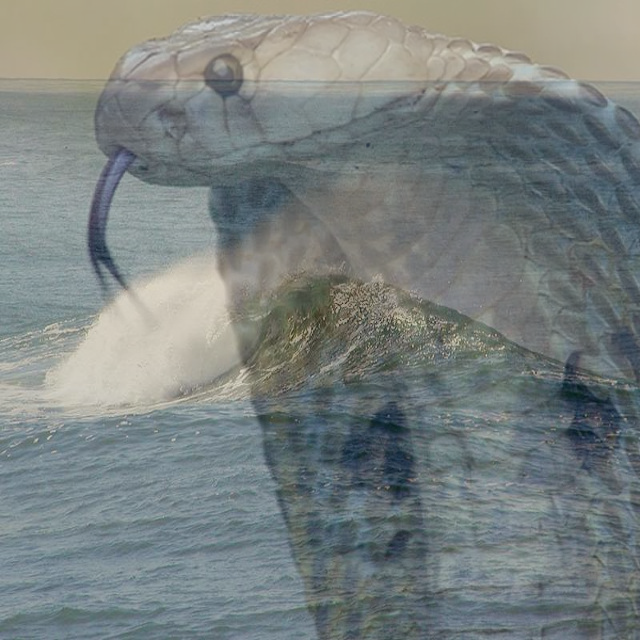

In [137]:
from IPython.display import Image
Image(filename='img2.png') 

In [3]:
#  http://stackoverflow.com/questions/890051/how-do-i-generate-circular-thumbnails-with-pil

from PIL import Image, ImageOps

mask = Image.open('mask_black.png').convert('L')
im = Image.open('output.png')
output = ImageOps.fit(im, mask.size, centering=(0.5, 0.5))
output.putalpha(mask)
output.save('output2.png')

In [46]:
#Making one blended image
#import Image
from PIL import Image
background = Image.open("800px-Tioman_Rainforest.png")
background = background.convert("RGBA")
overlay = Image.open("_s.jpg")
overlay = overlay.convert("RGBA")
new_img = Image.blend(background, overlay, 0.5)
new_img.save("Rainforest.png","PNG")

ValueError: images do not match

In [99]:
%matplotlib inline
import sys
from matplotlib import pyplot as plt
import numpy as np
import time as t
import cv2
print "OpenCV Version : %s " % cv2
print "------------------------------------"
#import module-of-interest
#IPython.paths.get_ipython_module_path(module_str)

print(sys.version)



OpenCV Version : <module 'cv2' from '/root/anaconda/lib/python2.7/site-packages/cv2.so'> 
------------------------------------
2.7.13 |Anaconda 2.0.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


*[HOME](#HOME)

<a id="mathplot"></a>

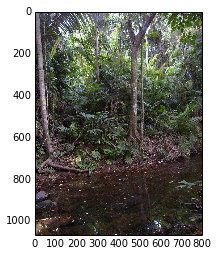

In [18]:
# GOOD BLOCK
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('800px-Tioman_Rainforest.JPG', 'r')
imshow(np.asarray(pil_im))

In [132]:
import Image

im = Image.open('/notebooks/src/input8.jpg')
im.save('wave.jpg')


*[HOME](#HOME)

<a id = "blending"></a>

### Making a Single Blended Image


In [5]:
%%bash
wget "https://images-na.ssl-images-amazon.com/images/G/01/aplusautomation/vendorimages/d25af680-c636-4f55-b142-11b7aa25d434.jpg._CB308687365_.jpg"

--2017-04-21 04:55:40--  https://images-na.ssl-images-amazon.com/images/G/01/aplusautomation/vendorimages/d25af680-c636-4f55-b142-11b7aa25d434.jpg._CB308687365_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 54.230.211.93, 54.230.211.52, 54.230.211.241, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|54.230.211.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26307 (26K) [image/jpeg]
Saving to: ‘d25af680-c636-4f55-b142-11b7aa25d434.jpg._CB308687365_.jpg’

     0K .......... .......... .....                           100%  629K=0.04s

2017-04-21 04:55:41 (629 KB/s) - ‘d25af680-c636-4f55-b142-11b7aa25d434.jpg._CB308687365_.jpg’ saved [26307/26307]



In [3]:
%%bash
wget "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Dry_rainforest.jpg/800px-Dry_rainforest.jpg"

--2017-04-21 04:27:05--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Dry_rainforest.jpg/800px-Dry_rainforest.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240838 (235K) [image/jpeg]
Saving to: ‘800px-Dry_rainforest.jpg’

     0K .......... .......... .......... .......... .......... 21% 80.8K 2s
    50K .......... .......... .......... .......... .......... 42% 85.8K 2s
   100K .......... .......... .......... .......... .......... 63% 91.3K 1s
   150K .......... .......... .......... .......... .......... 85% 90.4K 0s
   200K .......... .......... .......... .....                100%  164K=2.5s

2017-04-21 04:27:08 (93.5 KB/s) - ‘800px-Dry_rainforest.jpg’ saved [240838/240838]



In [63]:
%%bash
wget "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Tioman_Rainforest.JPG/800px-Tioman_Rainforest.JPG"

--2017-04-21 11:37:24--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Tioman_Rainforest.JPG/800px-Tioman_Rainforest.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298009 (291K) [image/jpeg]
Saving to: ‘800px-Tioman_Rainforest.JPG.1’

     0K .......... .......... .......... .......... .......... 17%  116K 2s
    50K .......... .......... .......... .......... .......... 34%  234K 1s
   100K .......... .......... .......... .......... .......... 51%  254K 1s
   150K .......... .......... .......... .......... .......... 68%  216K 0s
   200K .......... .......... .......... .......... .......... 85%  254K 0s
   250K .......... .......... .......... .......... .         100%  279K=1.4s

2017-04-21 11:37:26 (205 KB/s) - ‘800px-Tioman_Rainforest.JPG.1’ saved [298009/298009]



import os
os.listdir("/notebooks/exp/frames")

%%bash
ls /notebooks/src

In [ ]:
%%bash
apt-get -y install libgtk2.0-dev

In [ ]:
d25af680-c636-4f55-b142-11b7aa25d434.jpg._CB308687365_.jpg

In [42]:
%%bash
ls

0001a.png
0001.jpg
0001.thumbnail
0002.jpg
0003.jpg
0004.jpg
0005.jpg
0006.jpg
0007.jpg
0008.jpg
0009.jpg
0010.jpg
0011.jpg
0012.jpg
0013.jpg
0014.jpg
0015.jpg
0016.jpg
0017.jpg
0018.jpg
0019.jpg
0020.jpg
0021.jpg
0105.png
0105.thumbnail
0200.png
0200.thumbnail
032.jpg
1.jpg
200x100-red.png
22_04_2017_06:43:55.jpg
22_04_2017_06:44:16.jpg
22_04_2017_06:44:37.jpg
22_04_2017_06:44:59.jpg
22_04_2017_06:45:19.jpg
22_04_2017_06:45:39.jpg
22_04_2017_06:46:00.jpg
22_04_2017_06:46:21.jpg
22_04_2017_06:46:43.jpg
22_04_2017_06:47:03.jpg
25.jpg
2.jpg
300x300-black.png
300x300-red.png
3d-Plotly-graphs.ipynb
3d_scatter.ipynb
3.jpg
3rdparty
abc.png
AGE
a_gray
a_gray.jpg
a_gray.png
a.jpg
ant2.jpg
ant2.png
ant_over.jpg
ant.png
a.png
apps
APR22
APR22_IMG
array_stuff.jpg
a_test.png
basic 3d surface (1).ipynb
basic 3d surface.ipynb
batcountry
batcountry.py
batdream.py
bin
b.jpg
black-rgba.png
black-rgb.png
blend_modes.txt
blend.mp4
book_270 (1).epub
book_270.epub
b.png
bvlc_googlenet.caffemodel
caffe_erro

In [41]:
# import the necessary packages
import cv2
from PIL import Image

#im = Image.open('/notebooks/src/input8.jpg')
# load the image and show it
image = cv2.imread("800px-Tioman_Rainforest.jpg")

im = Image.open('800px-Tioman_Rainforest.jpg')

#cv2.imshow('ImageWindow',img)
#cv2.waitKey()

#cropped = image[70:170, 440:540]
r = 100.0 / image.shape[1]
dim = (100, int(image.shape[0] * r))
 
# perform the actual resizing of the image and show it
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

cv2.imshow("resized", resized)
cv2.waitKey(0)




#cv2.imshow("original", image)
#cv2.waitKey(0)
#21-001

IOError: [Errno 2] No such file or directory: '800px-Tioman_Rainforest.jpg'

run -m trace nidtN:b:pD:l:rs:T:em:G /notebooks/exp/frames/experiments.ipynb

In [20]:
print image.shape

(1067, 800, 3)


In [88]:
%%bash
which python

/root/anaconda/bin/python


In [89]:
import sys

print(sys.executable)

/root/anaconda/bin/python


import sys
sys.path

In [8]:
import os
path = os.path.dirname(cv2.__file__)
print path

/root/anaconda/lib/python2.7/site-packages


In [1]:
%%bash
ls /root/anaconda/lib/python2.7/site-packages

argcomplete
argcomplete-0.6.7-py2.7.egg-info
astropy
astropy-0.3.2-py2.7-linux-x86_64.egg-info
atom
atom-0.3.7-py2.7-linux-x86_64.egg-info
backports
backports.ssl_match_hostname-3.4.0.2-py2.7.egg-info
beautifulsoup4-4.3.1-py2.7.egg-info
binstar-0.5.3-py2.7.egg-info
binstar_client
bitarray
bitarray-0.8.1-py2.7.egg-info
blaze
blaze-0.5-py2.7.egg-info
blend_modes
blend_modes-1.0.1-py2.7.egg-info
blz
blz-0.6.2-py2.7.egg-info
bokeh
bokeh-0.4.4-py2.7.egg-info
boto
boto-2.28.0-py2.7.egg-info
bs4
cairo
casuarius-1.1-py2.7.egg-info
casuarius.so
cdecimal-2.3-py2.7.egg-info
cdecimal.so
cffi
cffi-1.9.1-py2.7.egg-info
_cffi_backend.so
chaco
chaco-4.4.1-py2.7-linux-x86_64.egg-info
colorama
colorama-0.2.7-py2.7.egg-info
conda
conda-4.3.16-py2.7.egg-info
conda_build
conda_build-1.3.5-py2.7.egg-info
conda_env
configobj-5.0.5-py2.7.egg-info
configobj.py
configobj.pyc
Crypto
cryptography
cryptography-1.7.1-py2.7.egg-info
cubes
cubes-0.10.2-py2.7.egg-info
curl
Cython
Cython-0.20.1-py2.7.egg-info
cython.py

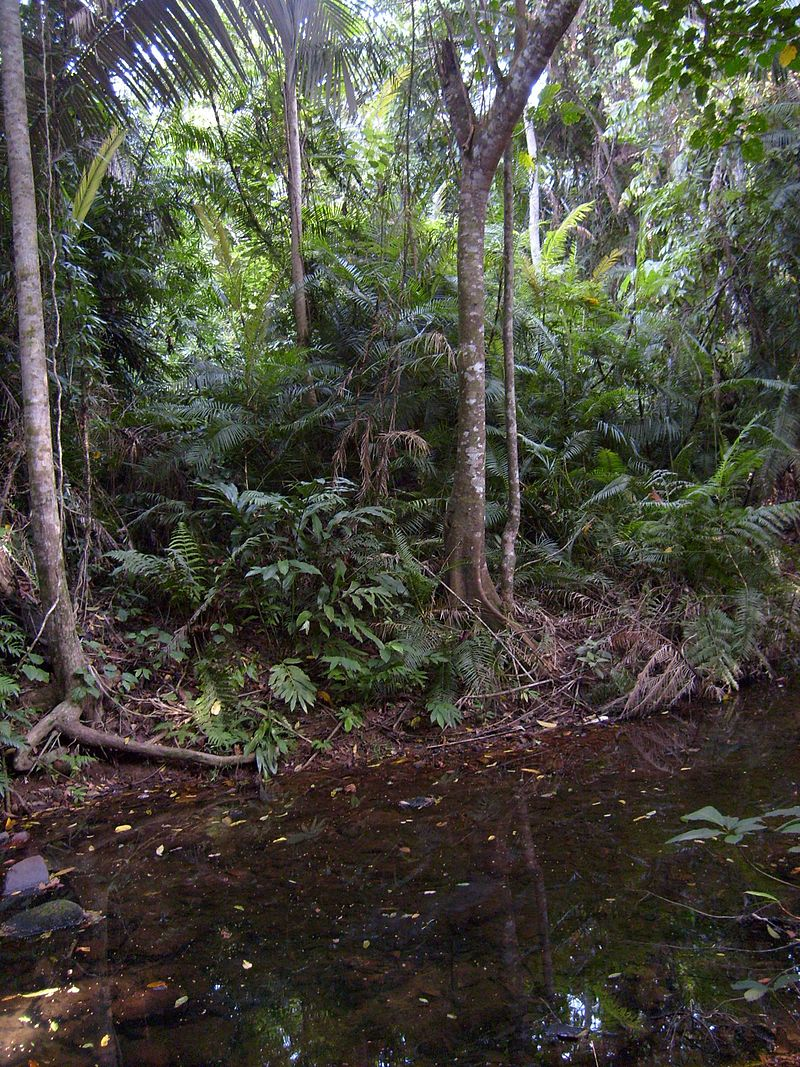

In [11]:
from IPython.display import Image 
Image(filename='800px-Tioman_Rainforest.JPG')

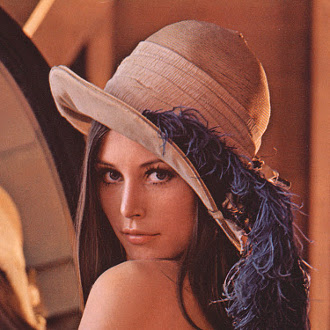

In [90]:
from IPython.display import Image 
Image(filename='images/lena.jpg')

In [104]:
#Making one blended image
import Image
background = Image.open("/notebooks/snake640.jpg")
overlay = Image.open("/notebooks/wave.png")
background = Image.open("/notebooks/snake640.jpg")
background = background.convert("RGBA")
overlay = Image.open("/notebooks/wave.png")
overlay = overlay.convert("RGBA")
new_img = Image.blend(background, overlay, 0.5)
new_img.save("snakewave.png","PNG")

In [105]:
import Image

im = Image.open('/notebooks/snakewave.png')
im.save('snakewave.jpg')


###Making a series os blended images

In [137]:
#Making a series os blended images
import Image

background = Image.open("/notebooks/src/1.jpg")
overlay = Image.open("/notebooks/src/2.jpg")

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")
#auto encrement while changing alpha value of overlay
for i in range(2):
    imagea = i *.1
    new_img = Image.blend(background, overlay, imagea)
    new_img.save('morph_001%d.png'%(i,),"PNG")


#count = count + .1


In [74]:
from IPython.display import Image 
from cStringIO import StringIO
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()                      
    PIL.Image.fromarray(a).save(f, fmt) 
    display(Image(data=f.getvalue()))   
#img = np.float32(PIL.Image.open('/notebooks/APR22_IMG/400.jpg'))
#showarray(img)

from IPython.display import clear_output, Image, display
imz = np.float32(PIL.Image.open('/notebooks/APR22/store/0001.jpg'))   
showarray(imz)

IOError: [Errno 2] No such file or directory: '/notebooks/APR22/store/0001.jpg'

In [14]:
pu = 'inception_5a/output'
_ = deepdream(net, imz, jitter = 0, iter_n=6, octave_n=8,  end = pu)

ValueError: operands could not be broadcast together with shapes (4,533,533) (3,1,1) 

In [7]:
import cv2
cv2.imwrite('dream1.jpg',_)

TypeError: img is not a numpy array, neither a scalar

In [56]:
from PIL import Image
img = Image.open('/notebooks/dream.jpg', 'r')
img_w, img_h = img.size
background = Image.new('RGBA', (680, 680), (255, 255, 235, 255))
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(img, offset)
background.save('dream-bordered.jpg')

In [10]:
!ls images

0001a.jpg	0032.jpg  0056.png  0081.jpg	  alargeplanet.png
0001.jpg	0032.png  0057.jpg  0081.png	  amarket.jpg
0001.png	0033.jpg  0057.png  0082.png	  ant.png
0001.thumbnail	0033.png  0058.jpg  0083.jpg	  ariver002.jpg
0002.jpg	0034.png  0058.png  0083.png	  ariver.jpg
0002.png	0035.png  0059.jpg  0084.jpg	  asky.JPG
0003.jpg	0036.jpg  0059.png  0084.png	  a_test.png
0004.jpg	0037.jpg  0060.jpg  0085.jpg	  athought.JPG
0004.png	0037.png  0060.png  0085.png	  awaterfall.jpg
0005.jpg	0038.jpg  0061.png  0086.jpg	  d-0020.png.jpg
0005.png	0038.png  0062.jpg  0086.png	  dream-bordered.jpg
0007.jpg	0039.jpg  0063.jpg  0087.jpg	  elephant.jpg
0008.jpg	0039.png  0063.png  0087.png	  face.jpg
0008.png	0040.jpg  0064.jpg  0088.jpg	  Fract2.jpg
0009.jpg	0040.png  0064.png  0088.png	  gray_con.png
0009.png	0042.jpg  0066.jpg  0089.jpg	  gray_conrgb.png
0010.jpg	0042.png  0066.png  0089.png	  gray_conrgbtran.png
0011.jpg	0043.png  0068.jpg  0090.jpg	  imagenet-sample.jpg
0012.jpg	0044.jpg  0068.png

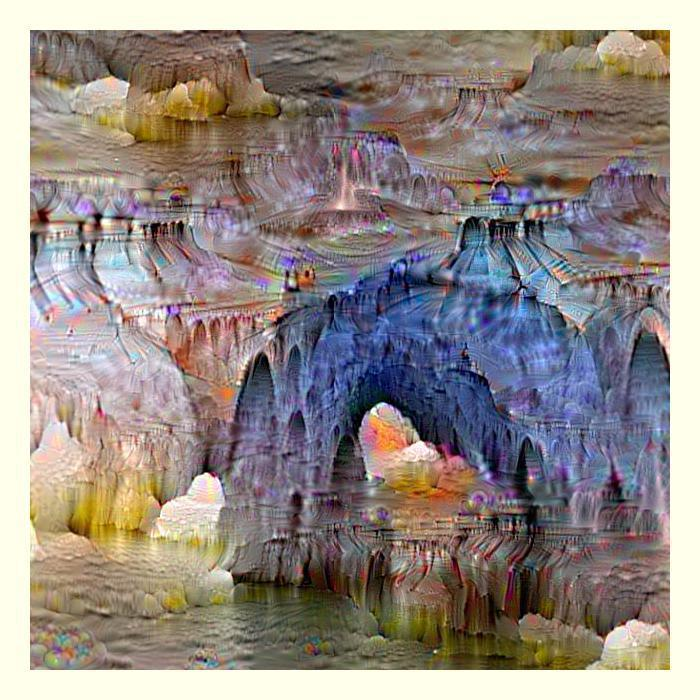

In [11]:
import PIL.Image
from cStringIO import StringIO
def showarray(a, fmt='jpeg'):
    from IPython.display import clear_output, Image, display
    
    #a = np.uint8(np.clip(a, 0, 255))
    a = np.uint8(np.clip(a, 0, 255))
# Convert and clip our matrix into the jpeg constraints (0-255 values for Red, Green, Blue)
        
    f = StringIO()                      
    # Our string file handler
    
    PIL.Image.fromarray(a).save(f, fmt) 
    # Rather than saving to a file each time, save to our string handler
    
    display(Image(data=f.getvalue()))   
    # Display the image in our notebook, using the IPython.display, and IPython.Image helpers.
    
styliz = np.float32(PIL.Image.open('images/index.jpeg'))
showarray(styliz)


%%bash
locate .ttf


In [157]:
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 15)
#img = Image.new("RGBA", (200,200), (120,20,20))
img = Image.open("/notebooks/dream-bordered.jpg")
draw = ImageDraw.Draw(img)
draw.text((50,5), "googlenet_places365.caffe int-20 oct-8 inception_5a/output ", (0,0,0), font=font)
draw = ImageDraw.Draw(img)
img.save("a_test.png")

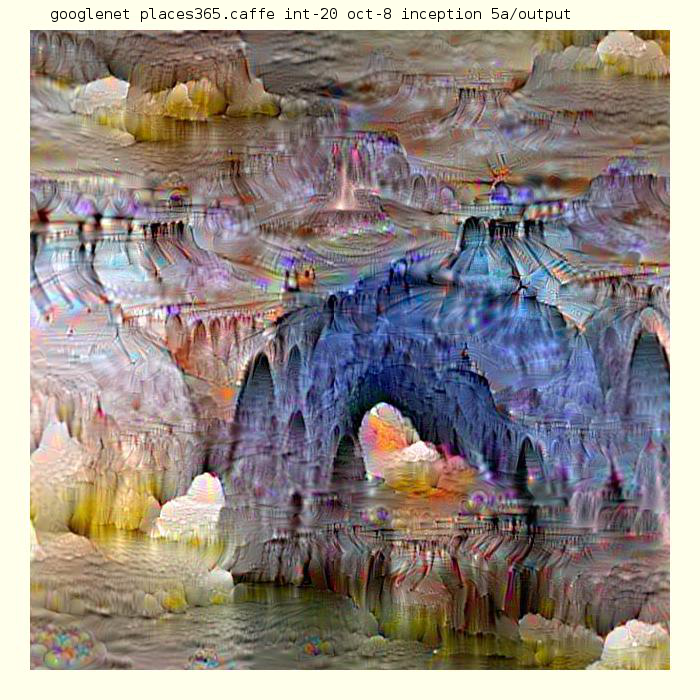

In [158]:
from IPython.display import Image 
Image(filename='/notebooks/a_test.png')

In [65]:
%%bash 
fc-list

/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf: DejaVu Serif:style=Bold
/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf: DejaVu Sans Mono:style=Book
/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf: DejaVu Sans:style=Book
/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf: DejaVu Sans:style=Bold
/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf: DejaVu Sans Mono:style=Bold
/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf: DejaVu Serif:style=Book


<a id = "cv2stuff"></a>

*[HOME](#HOME)

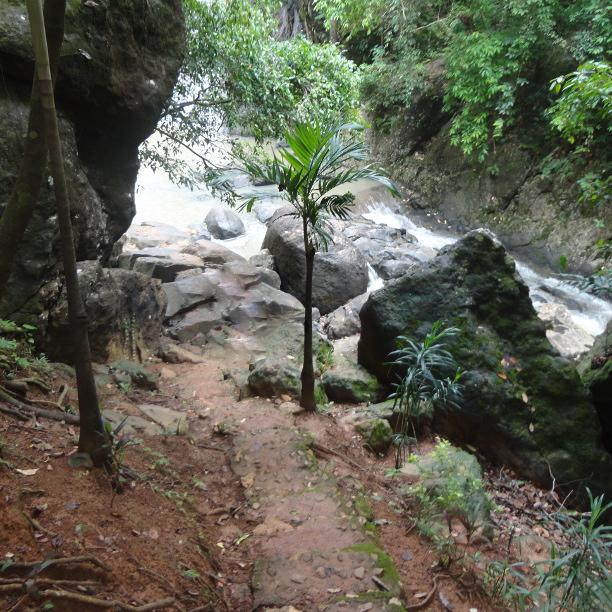

In [15]:
img2 = np.float32(PIL.Image.open('/notebooks/ariver.jpg'))
showarray(img2)


In [109]:
#experiment 
import cv2
cv2.imwrite('exp002.jpg', img2);

In [12]:
#create image _ with the first parameter, then feed it into the second parameter to be looped twice.
# iter_n=5, octave_n=5, octave_scale=1.4, 
_=deepdream(net, styliz, jitter=0, iter_n=30, octave_n=8, octave_scale=1.64, end='inception_5a/pool_proj')
PIL.Image.fromarray(np.uint8(_)).save("ariver001.jpg")

/home/jack/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ValueError: On entry to cblas_ parameter number 11 had an illegal value

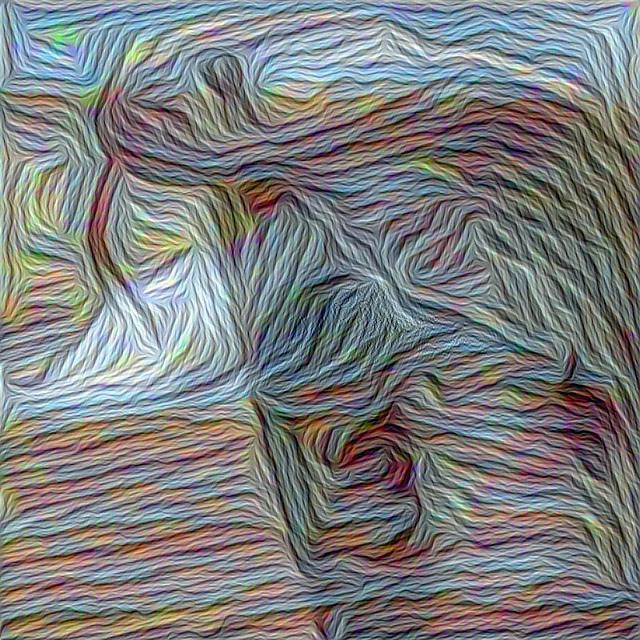

In [110]:
from IPython.display import Image 
Image(filename='/notebooks/exp002.jpg')

#create image _ with the first parameter, then feed it into the second parameter to be looped twice.
_=deepdream(net, img, jitter=0, end='conv2/3x3_reduce')

#_ = deepdream(net, img, end='inception_5a/output')
#for i in xrange(4):
#    _ = deepdream(net, _, end='inception_5b/pool_proj')


ni = deepdream(net, _, end='inception_5a/output')
for i in xrange(2):
    ni2 = deepdream(net, ni, end='inception_5b/pool_proj')

In [ ]:
net.blobs.keys()

In [85]:
_ = deepdream(net, _, end='inception_5a/1x1')

AttributeError: 'Image' object has no attribute 'ndim'

<a id="STORE"></a>

In [ ]:
http://www.py4inf.com/

[home](#HOME)

#Store a Generated Image

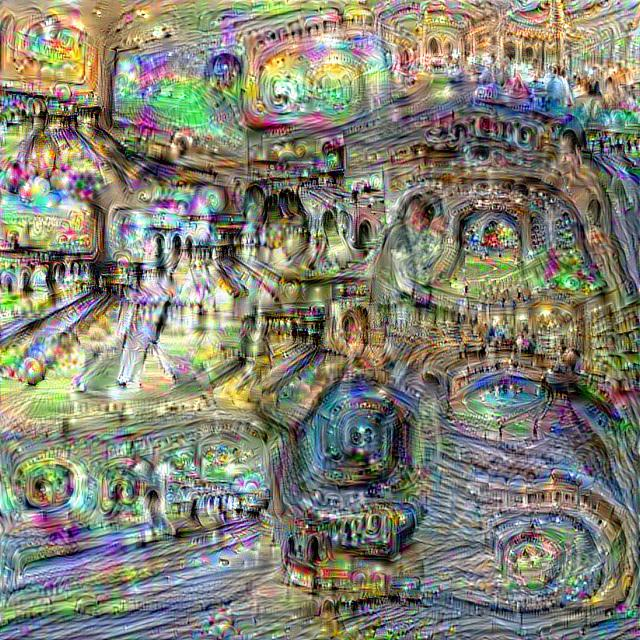

5 9 inception_5a/3x3_reduce (640, 640, 3)


In [153]:
_ = deepdream(net, _, end='inception_5a/3x3_reduce')
import cv2
cv2.imwrite('exp002.jpg', _);

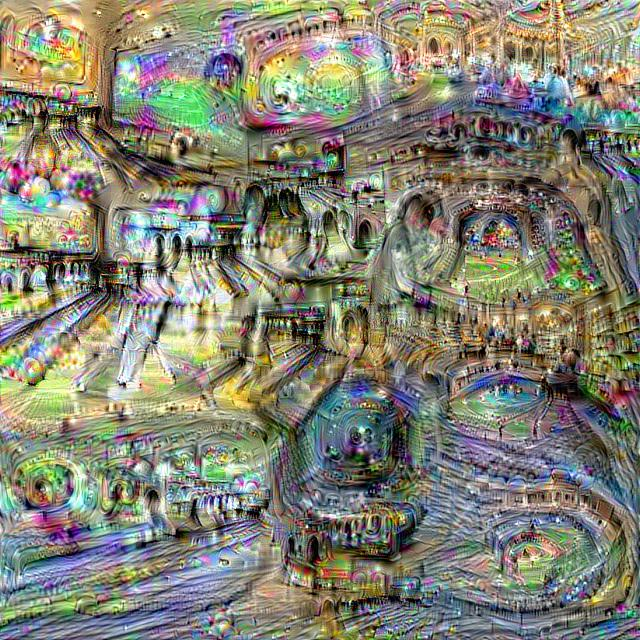

5 9 inception_5a/5x5_reduce (640, 640, 3)


In [154]:
_ = deepdream(net, _, end='inception_5a/5x5_reduce')

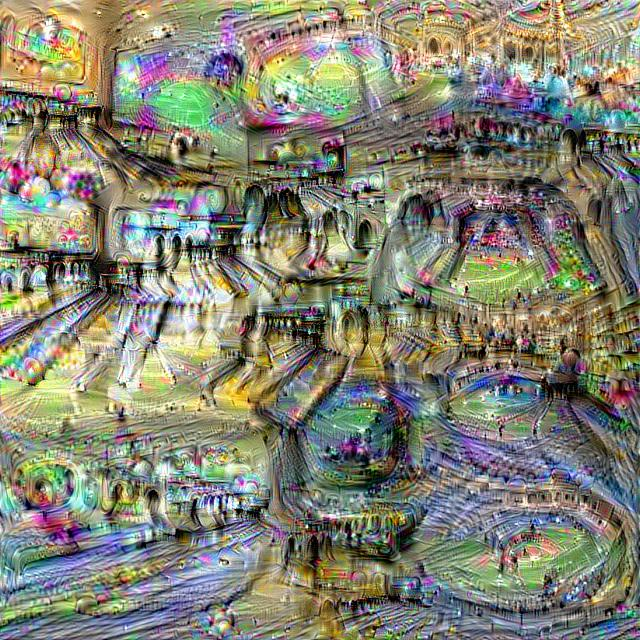

5 9 inception_5a/5x5 (640, 640, 3)


In [155]:
_ = deepdream(net, _, end='inception_5a/5x5')

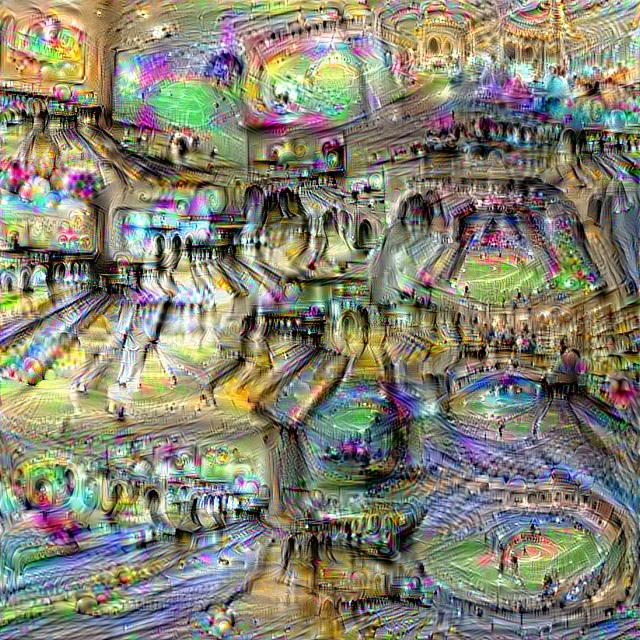

5 9 inception_5a/pool (640, 640, 3)


In [156]:
_ = deepdream(net, _, end='inception_5a/pool')

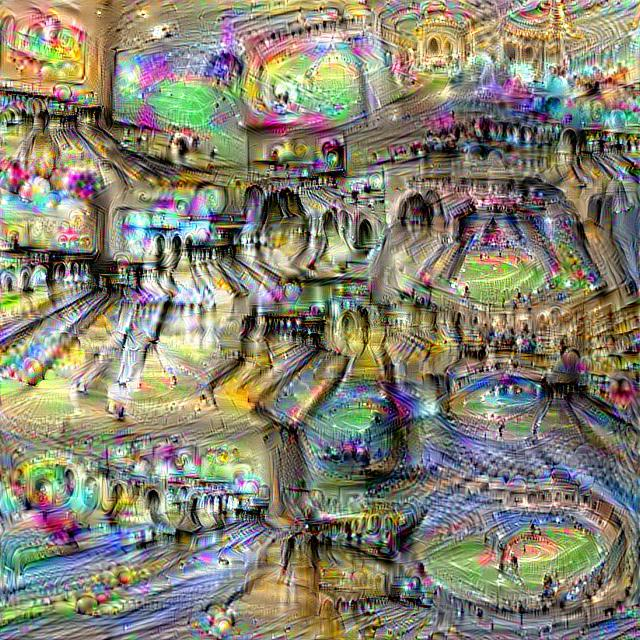

5 9 inception_5a/pool_proj (640, 640, 3)


In [157]:
_ = deepdream(net, _, end='inception_5a/pool_proj')

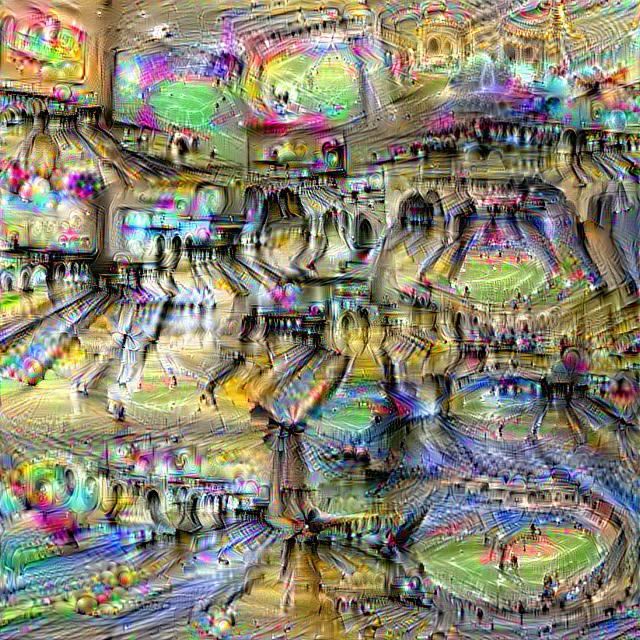

5 19 inception_5a/output (640, 640, 3)


In [158]:
_ = deepdream(net, _, iter_n=50, end='inception_5a/output')

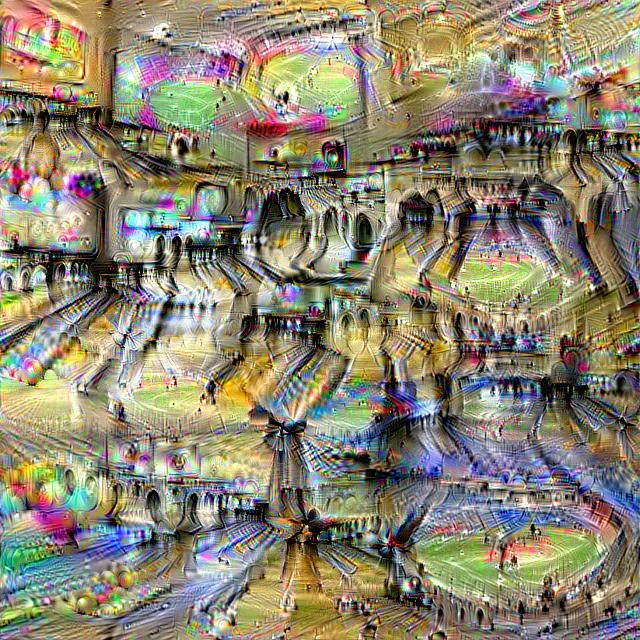

5 9 inception_5b/pool_proj (640, 640, 3)


In [159]:
#create image _ with the first parameter, then feed it into the second parameter to be looped twice.

_ = deepdream(net, _, end='inception_5a/output')
for i in xrange(4):
    _ = deepdream(net, _, iter_n=20, end='inception_5b/pool_proj')

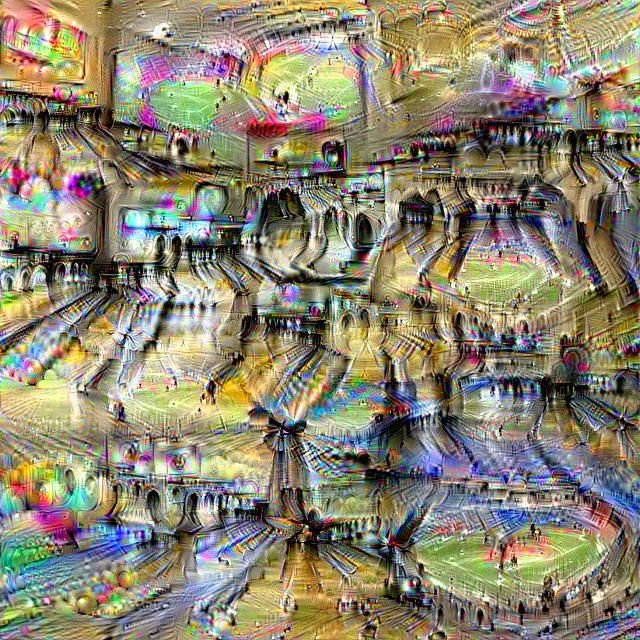

5 9 inception_5a/output (640, 640, 3)


In [ ]:
_ = deepdream(net, _, jitter=0, end='inception_5a/output')

In [ ]:
_ = deepdream(net, _, iter_n=50, end='inception_5b/pool_proj')
for i in xrange(4):
    _ = deepdream(net, _, iter_n=50, end='inception_5b/pool_proj')

In [ ]:
_ = deepdream(net, _, jitter=0,iter_n=30, end='inception_4e/5x5_reduce')
for i in xrange(8):
 _ = deepdream(net, _, jitter=0, iter_n=30, end='inception_5a/output')

In [ ]:
!mkdir newsave

frame = _
frame_i = 0

mkdir: cannot create directory ‘newsave’: File exists


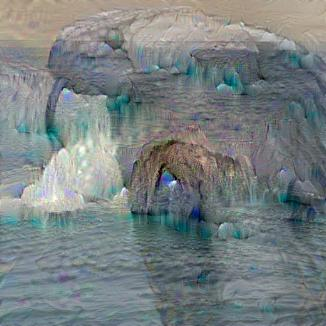

3 3 inception_5a/output (326, 326, 3)


In [ ]:
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(300):
    
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("newsave/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)


    showarray(img)

    
    frame_i += 1
    
img = np.float32(PIL.Image.open('newsave/0015.jpg'))    

In [ ]:
img= np.float32(PIL.Image.open('/notebooks/src/input13.jpg')) # Guide must be 320x240 pixels or below!
showarray(img)

In [ ]:
guide = np.float32(PIL.Image.open('/notebooks/src/input13.jpg')) # Guide must be 320x240 pixels or below!
showarray(guide)

In [ ]:
end = 'inception_5b/1x1'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()
#shutil.copy(guide_features, '/notebooks/src')

In [ ]:
import shutil
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

frame = img
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
_ = deepdream(net, img, jitter=0,  iter_n=20,  objective=objective_guide, end=end)
_ = deepdream(net, _, jitter=0,  iter_n=20, objective=objective_guide, end=end)
#shutil.copy('dreamed/' + str(i) + '.jpg', '/src/done')
#shutil.copy(_ + end + '_001.jpg', '/notebooks/src')

In [ ]:
end = 'inception_5a/pool'
h, w = _.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, _)
net.forward(end=end)
guide_features = dst.data[0].copy()
#shutil.copy(guide_features, '/notebooks/src')

In [ ]:
import shutil
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

frame = _
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
_ = deepdream(net, img, jitter=0, objective=objective_guide, end=end)
_ = deepdream(net, _, jitter=0, objective=objective_guide, end=end)
#shutil.copy('dreamed/' + str(i) + '.jpg', '/src/done')
#shutil.copy(_ + end + '_001.jpg', '/notebooks/src')

In [ ]:
import glob    # used to get list of all jpegs in directory
import timeit  # used to time how long it's gonna take

start_time = timeit.default_timer() # start the timer before we start

num_files = 0
for filename in glob.glob('/notebooks/src/*.jpg'):
    img = np.float32(PIL.Image.open(filename))   # open the first image
    print num_files + filename
    frame = deepdream(net, img, end=end, objective=objective_guide) # deep dream it, this is using guided.
    PIL.Image.fromarray(np.uint8(frame)).save(num_files + filename) # Save it
    num_files += 1                               # increment file counter

elapsed = timeit.default_timer() - start_time
print "Ran through " + str(num_files) + " in " + str(elapsed) + "seconds. " + str(elapsed / num_files) + " seconds per image average."


In [ ]:
img = np.float32(PIL.Image.open('/notebooks/framesalex365/0001.jpg'))
showarray(img)



In [ ]:
guide = np.float32(PIL.Image.open('/notebooks/src/guide004.jpg')) # image max resolution of 320x240!
end = 'inception_4b/pool_proj' # change to your end layer
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

import timeit
start_time = timeit.default_timer()

img = np.float32(PIL.Image.open('/notebooks/src/output/*.jpg')) 
# assumes you've run `ffmpeg -i input.mp4 output%05d.jpg`, and all images are in same directory as script

h, w, c = img.shape  # get our video source's image size
hallu = deepdream(net, img, end=end, objective=objective_guide) # do the first deep dream
np.clip(hallu, 0, 255, out=hallu) # clip our RGB values to 255, don't go over!
PIL.Image.fromarray(np.uint8(hallu)).save('output/' + 'output00001.jpg') # save the first one
grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # create a greyscale of our image
num_files = 0 # start a counter

for filename in glob.glob('*.jpg'):
    if num_files == 0:
        num_files += 1 # skip the first image, we've already done it, and made our variables available in this scope
        continue
    previousImg = img  # use the previous img as a reference to calculate optical flow
    previousGrayImg = grayImg  # and the same for greyscale
    img = np.float32(PIL.Image.open(filename)) # load current image
    grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # create new greyscale
    flow = cv2.calcOpticalFlowFarneback(previousGrayImg, grayImg, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    # calculate opticalflow from opencv. feel free to go wild with options, playing until you find what fits.

    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    halludiff = hallu - previousImg
    halludiff = cv2.remap(halludiff, flow, None, cv2.INTER_LINEAR)  # fit hallucination to the flow difference 
    hallu = img + halludiff # add it back to the image
    hallu = deepdream(net, hallu, end=end, objective=objective_guide)
    np.clip(hallu, 0, 255, out=hallu)
    PIL.Image.fromarray(np.uint8(hallu)).save('output/' + filename)
    print "Finished file number " + str(num_files) + ", out of " + str(len(glob.glob('*.jpg'))) + " files. "
    num_files += 1

elapsed = timeit.default_timer() - start_time
print "Ran through " + str(num_files) + " in " + str(elapsed) + "seconds. " + str(elapsed / images) + " seconds per image average."

In [ ]:
import scipy.misc
import numpy as np

# Image size
width = 640
height = 480
channels = 3

# Create an empty image
imgc = np.zeros((height, width, channels), dtype=np.uint8)

# Draw something (http://stackoverflow.com/a/10032271/562769)
xx, yy = np.mgrid[:height, :width]
circle = (xx - 100) ** 2 + (yy - 100) ** 2

# Set the RGB values
for y in range(imgc.shape[0]):
    for x in range(imgc.shape[1]):
        r, g, b = circle[y][x], circle[y][x], circle[y][x]
        imgc[y][x][0] = r
        imgc[y][x][1] = g
        imgc[y][x][2] = b

# Display the image
#scipy.misc.imshow(imgc)
showarray(imgc)
# Save the image
#scipy.misc.imsave("image.png", img)

#exp = np.float32(PIL.Image.imgc)
#showarray(exp)




In [2]:
#"""Print a swatch using all 256 colors of 256-color-capable terminals."""
def hrun(start, width, padding=0):
    return [None] * padding + list(range(start, start + width)) + [None] * padding
def vrun(start, width, height, padding=0):
    return [hrun(s, width, padding)
            for s in range(start, start + width * height, width)]
layout = [
    vrun(0, 8, 2),                # 16 standard xterm colors
    vrun(16, 6, 6 * 6, 1),        # 6x6x6 color cube
    vrun(16 + 6 * 6 * 6, 8, 3),   # 24 grey levels
]
def fg_seq(color):
    return '\033[38;5;%dm' % color
def bg_seq(color):
    return '\033[48;5;%dm' % color
reset_seq = '\033[0m'
def color_bar(seq, color, trail):
    if color is None:
        return '%s    %s' % (reset_seq, trail)
    else:
        return '%s %03d%s' % (seq(color), color, trail)
def main():
    for block in layout:
        print("")
        for row in block:
            fg_bar = ''.join(color_bar(fg_seq, color, '') for color in row)
            bg_bar = ''.join(color_bar(bg_seq, color, ' ') for color in row)
            print('%s%s    %s%s' % (fg_bar, reset_seq, bg_bar, reset_seq))
if __name__ == '__main__':
    main()


 000 001 002 003 004 005 006 007     000  001  002  003  004  005  006  007 
 008 009 010 011 012 013 014 015     008  009  010  011  012  013  014  015 

     016 017 018 019 020 021              016  017  018  019  020  021      
     022 023 024 025 026 027              022  023  024  025  026  027      
     028 029 030 031 032 033              028  029  030  031  032  033      
     034 035 036 037 038 039              034  035  036  037  038  039      
     040 041 042 043 044 045              040  041  042  043  044  045      
     046 047 048 049 050 051              046  047  048  049  050  051      
     052 053 054 055 056 057              052  053  054  055  056  057      
     058 059 060 061 062 063              058  059  060  061  062  063      
     064 065 066 067 068 069              064  065  066  067  068  069      
     070 071 072 073 074 075              070  071  072  073  074  075      
     076 077 078 079 080 081              076  077  078  079  080  081    

In [3]:
import cv2

im3 = cv2.imread("/notebook/snake640.jpg");

imout = cv2.detailEnhance(im3);
cv2.imwrite("detail-enhance.jpg", imout);

error: /root/mc-x64-2.7/conda-bld/opencv-3_1482256854890/work/opencv-3.1.0/modules/imgproc/src/color.cpp:8206: error: (-215) (scn == 3 || scn == 4) && (depth == CV_8U || depth == CV_32F) in function cvtColor


In [9]:
'''
OpenCV Non-Photorealistic Rendering Python Example
Copyright 2015 by Satya Mallick <spmallick@gmail.com>
'''
import numpy as np 
import cv2
# Read image
im = cv2.imread("/notebooks/snake1200.jpg");
# Edge preserving filter with two different flags.
imout = cv2.edgePreservingFilter(im, flags=cv2.RECURS_FILTER);
cv2.imwrite("edge-preserving-recursive-filter.jpg", imout);
imout = cv2.edgePreservingFilter(im, flags=cv2.NORMCONV_FILTER);
cv2.imwrite("edge-preserving-normalized-convolution-filter.jpg", imout);
# Detail enhance filter
imout = cv2.detailEnhance(im);
cv2.imwrite("detail-enhance.jpg", imout);
# Pencil sketch filter
imout_gray, imout = cv2.pencilSketch(im, sigma_s=60, sigma_r=0.07, shade_factor=0.05);
cv2.imwrite("pencil-sketch.jpg", imout_gray);
cv2.imwrite("pencil-sketch-color.jpg", imout);
# Stylization filter
cv2.stylization(im,imout);
cv2.imwrite("stylization.jpg", imout);



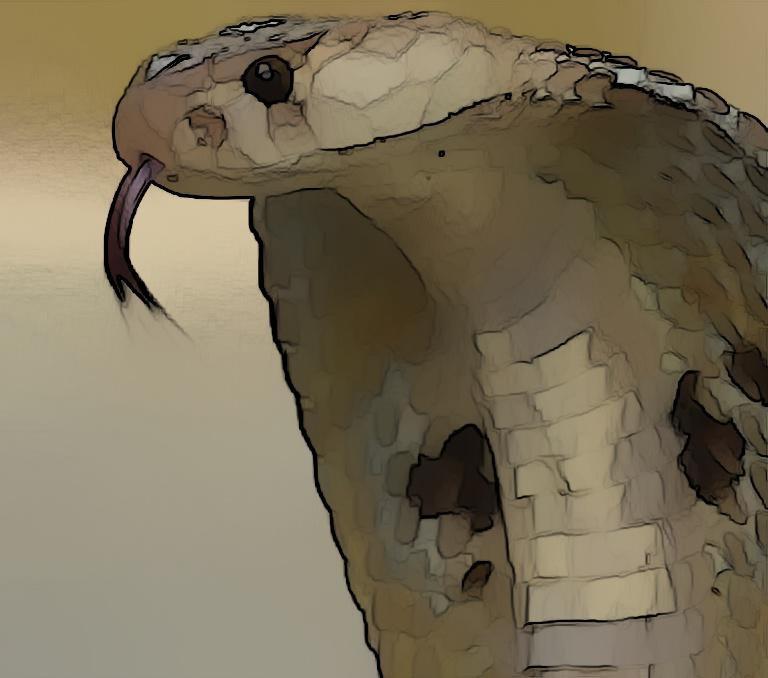

In [10]:
import PIL.Image
from cStringIO import StringIO
def showarray(a, fmt='jpeg'):
    from IPython.display import clear_output, Image, display
    
    #a = np.uint8(np.clip(a, 0, 255))
    a = np.uint8(np.clip(a, 0, 255))
# Convert and clip our matrix into the jpeg constraints (0-255 values for Red, Green, Blue)
        
    f = StringIO()                      
    # Our string file handler
    
    PIL.Image.fromarray(a).save(f, fmt) 
    # Rather than saving to a file each time, save to our string handler
    
    display(Image(data=f.getvalue()))   
    # Display the image in our notebook, using the IPython.display, and IPython.Image helpers.
    
styliz = np.float32(PIL.Image.open('/notebooks/stylization.jpg'))
showarray(styliz)


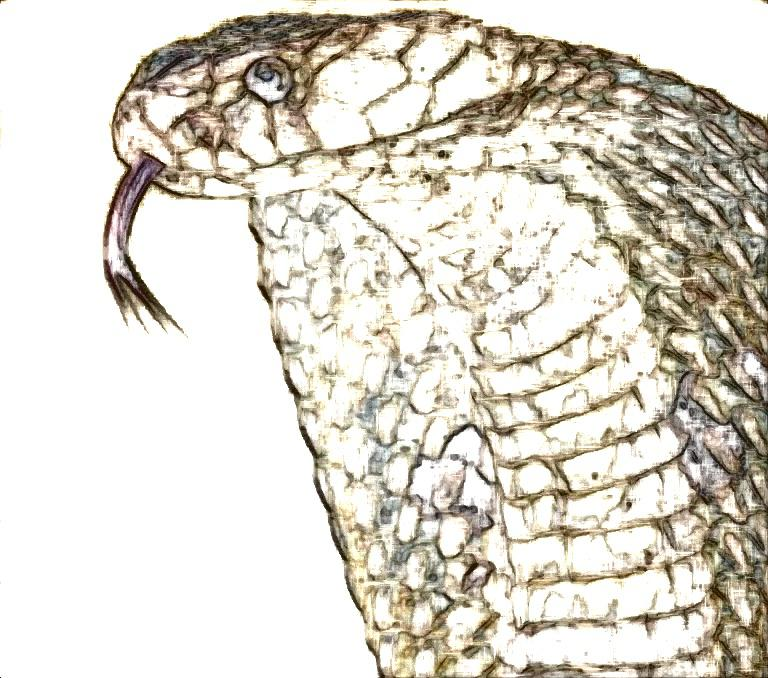

In [11]:
sketchcolor = np.float32(PIL.Image.open('/notebooks/pencil-sketch-color.jpg'))
showarray(sketchcolor)

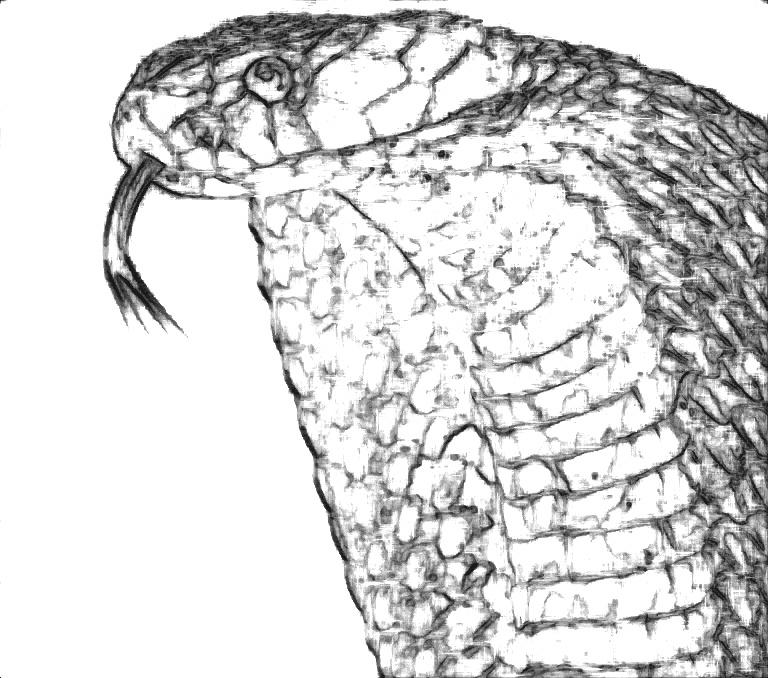

In [12]:
sketch = np.float32(PIL.Image.open('/notebooks/pencil-sketch.jpg'))
showarray(sketch)

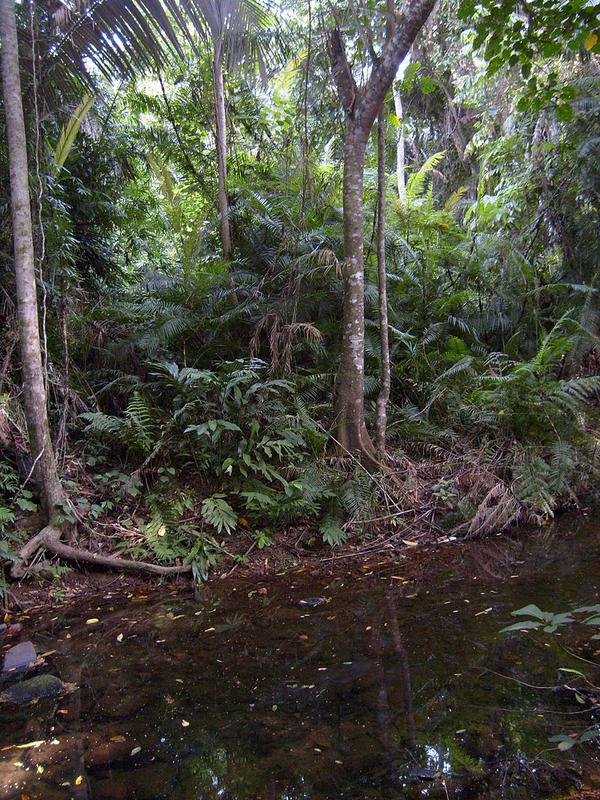

In [13]:
enhanced = np.float32(PIL.Image.open('/notebooks/APR22/store/0001.jpg'))
showarray(enhanced)

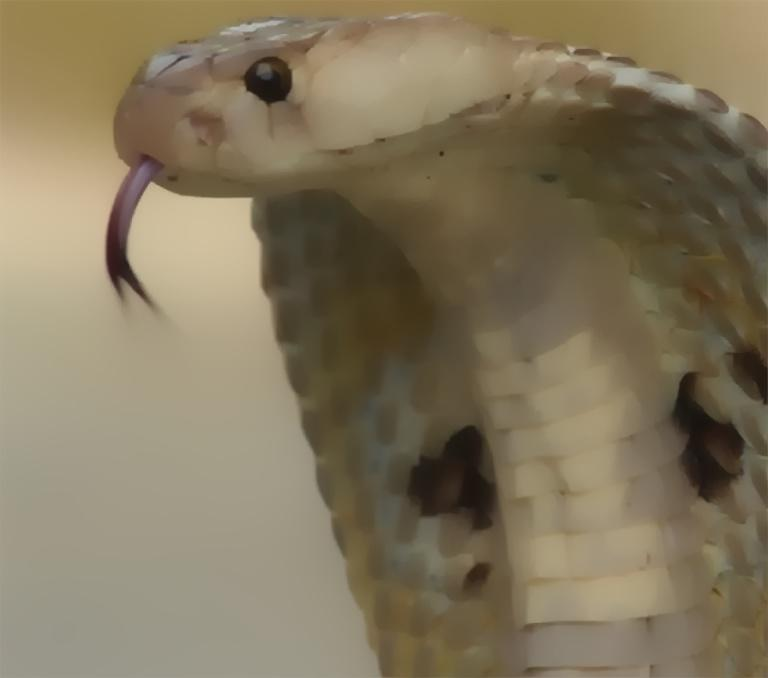

In [14]:
recursive = np.float32(PIL.Image.open('/notebooks/edge-preserving-recursive-filter.jpg'))
showarray(recursive)

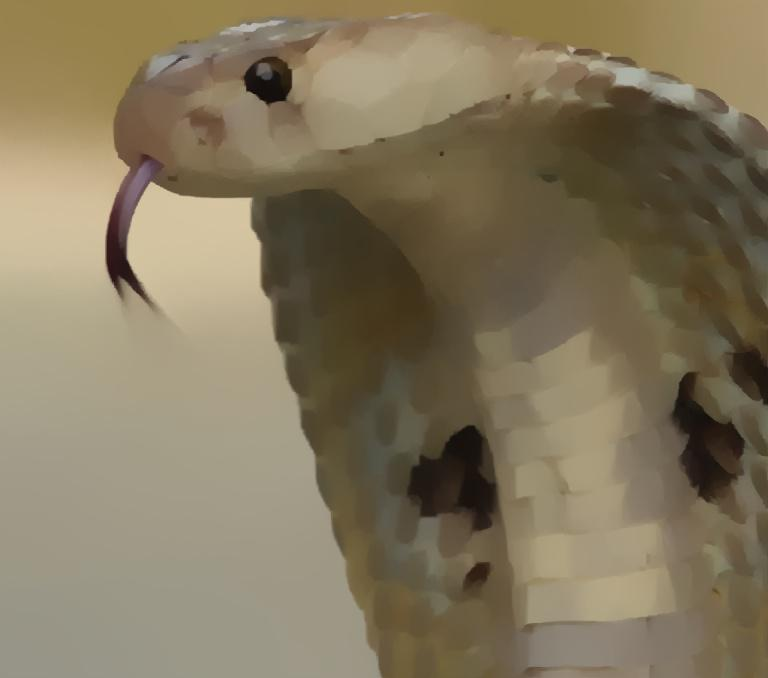

In [15]:
convolution = np.float32(PIL.Image.open('/notebooks/edge-preserving-normalized-convolution-filter.jpg'))
showarray(convolution)

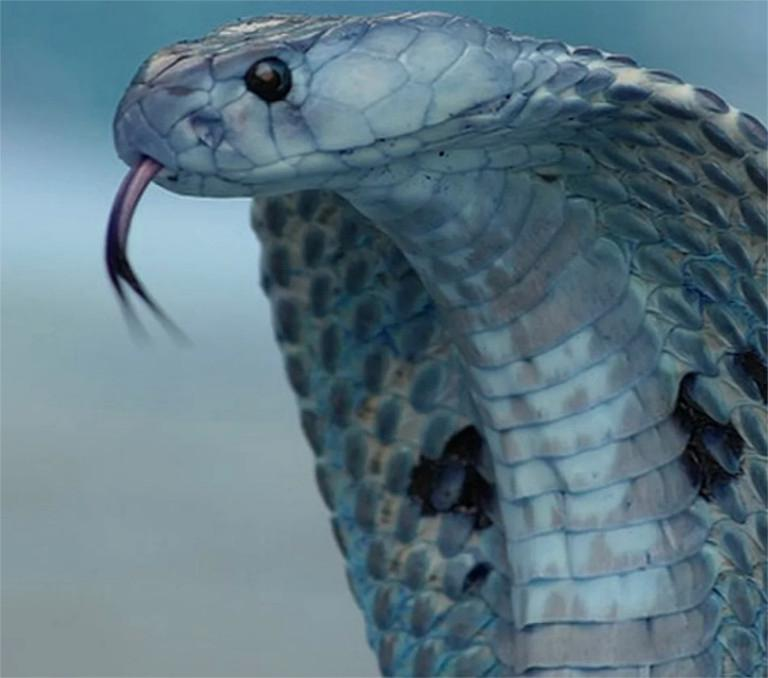

IOError: [Errno 2] No such file or directory: '800px-Tioman_Rainforest.png'

In [16]:
from PIL import Image
import PIL.Image
from IPython.display import clear_output, Image, display
import numpy as np
from IPython.display import Image 
from cStringIO import StringIO
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()                      
    PIL.Image.fromarray(a).save(f, fmt) 
    display(Image(data=f.getvalue()))   
    im = np.float32(PIL.Image.open('800px-Tioman_Rainforest.png'))   
showarray(im)

In [17]:
import cv2
import numpy as np 

# Read images
src = cv2.imread("/notebooks/snake640.jpg")
#dst = cv2.imread("/notebooks/edge-preserving-normalized-convolution-filter.jpg")
#src = cv2.imread("/notebooks/learnopencv/SeamlessCloning/images/airplane.jpg")
dst = cv2.imread("/notebooks/learnopencv/SeamlessCloning/images/sky.jpg")


# Create a rough mask around the airplane.
src_mask = np.zeros(src.shape, src.dtype)
#poly = np.array([ [4,80], [30,54], [151,63], [254,37], [298,90], [272,134], [43,122] ], np.int32)
poly = np.array([ [1,100], [1,50], [151,63], [254,37], [298,90], [272,134], [43,122] ], np.int32)
cv2.fillPoly(src_mask, [poly], (255, 255, 255))

# This is where the CENTER of the airplane will be placed
center = (812,150)

# Clone seamlessly.
output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)

# Write result
cv2.imwrite("/notebooks/cloning-example2.jpg", output);


#zzzzzzzzzzzzzzzzzzzzz

In [ ]:
convolution = np.float32(PIL.Image.open('/notebooks/cloning-example2.jpg'))
showarray(convolution)

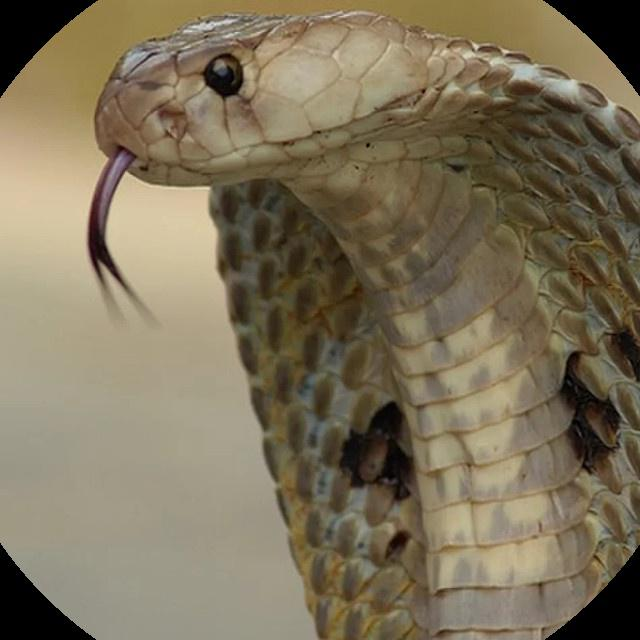

IOError: [Errno 2] No such file or directory: '800px-Tioman_Rainforest.png'

In [24]:
from time import sleep
sleep(0.1)
sizer = 400
#for i in range(40):
count = 0
while (count < 9):
    sleep(1)
    sizer = sizer -10    
    im = cv2.imread('/notebooks/snake640.jpg')
    height,width,depth = im.shape
    circle_img = np.zeros((height,width), np.uint8)
    cv2.circle(circle_img,(width/2,height/2),sizer,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=circle_img)
    cv2.imwrite("/notebooks/mask-example.jpg", masked_data);
    
    masked = np.float32(PIL.Image.open('/notebooks/mask-example.jpg'))
    showarray(masked)
    count = count + 1

#nice reference:
http://www.astro.ufl.edu/~warner/prog/python.html

In [25]:
import PIL
from PIL import Image
basewidth = 300
img = Image.open('/notebooks/cloning-example2.jpg')
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save('/notebooks/cloning-example2-smaller.jpg')

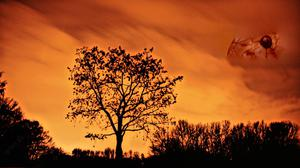

In [29]:
from IPython.display import Image 
Image(filename='/notebooks/cloning-example2-smaller.jpg')

In [ ]:
cv2.imwrite('messigray.png',img)

In [28]:
import re

# print all names exported by the module
print dir(re)


In [29]:
import cv2
cv2.__version__

'3.1.0'

In [18]:
import sys
sys.path

['',
 '/root/anaconda/lib/python2.7/site-packages/protobuf-3.0.0_alpha_1-py2.7.egg',
 '/caffe-master/distribute/python',
 '/root/anaconda/lib/python27.zip',
 '/root/anaconda/lib/python2.7',
 '/root/anaconda/lib/python2.7/plat-linux2',
 '/root/anaconda/lib/python2.7/lib-tk',
 '/root/anaconda/lib/python2.7/lib-old',
 '/root/anaconda/lib/python2.7/lib-dynload',
 '/root/anaconda/lib/python2.7/site-packages',
 '/root/anaconda/lib/python2.7/site-packages/PIL',
 '/root/anaconda/lib/python2.7/site-packages/runipy-0.1.0-py2.7.egg',
 '/root/anaconda/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg',
 '/root/anaconda/lib/python2.7/site-packages/IPython/extensions',
 '/root/.cache/scipy/python27_compiled']

In [17]:
import os

# print the module's online manual
print help(os)

# BACK UP STUFF

In [43]:
#do not touch working fine
from PIL import Image
#img = Image.open('800px-Tioman_Rainforest_.jpg', 'r')
img = Image.open('_s.jpg', 'r')
img_w, img_h = img.size
#background = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))
background = Image.open('800px-Tioman_Rainforest.png')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(img, offset)
background.save('out2a.png')
#do not touch working fine

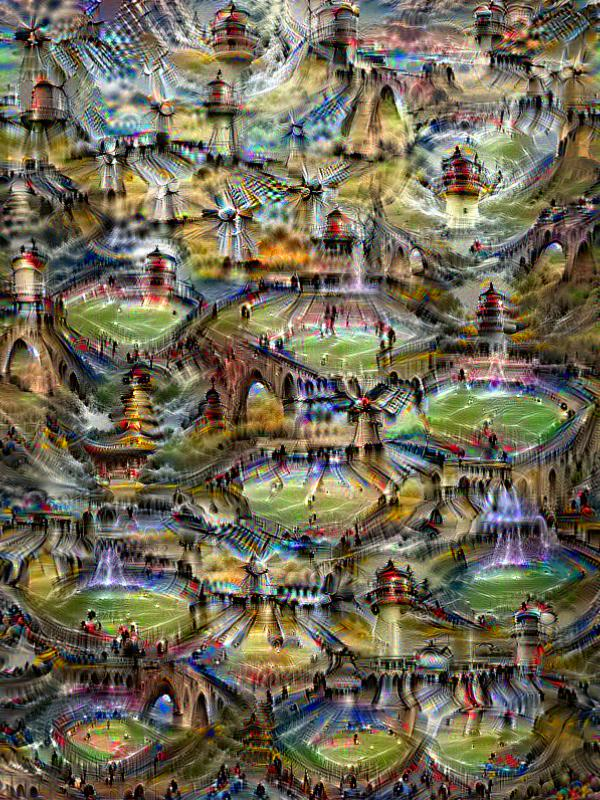

IOError: [Errno 2] No such file or directory: 'junk4/0002.jpg'

In [140]:
import PIL
#from PIL import Image
from IPython.display import clear_output, Image, display
!mkdir junk4
frame = imz
frame_i = 0
h, w = frame.shape[:2]
s = 0.005 # scale coefficient
for i in xrange(300):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("junk4/%04d.jpg"%frame_i)
    
from PIL import Image
basewidth = 60
inlay = Image.open("junk4/0000.jpg")
wpercent = (basewidth / float(inlay.size[0]))
hsize = int((float(inlay.size[1]) * float(wpercent)))
inlay = inlay.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
inlay.save('junk4/60.jpg')    



#do not touch working fine
#from PIL import Image
#img = Image.open('800px-Tioman_Rainforest_.jpg', 'r')
imgo = Image.open('junk4/60.jpg', 'r')
img_w, img_h = imgo.size
#background = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))
background = Image.open('junk4/0000.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(imgo, offset)
background.save('junk4/overlay001.png')
#do not touch working fine

    
    
    
from IPython.display import clear_output, Image, display  
frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
showarray(frame)
frame_i += 1

img = np.float32(PIL.Image.open('junk4/0002.jpg'))    

In [47]:
%%bash
updatedb

In [48]:
%%bash
locate mandelbrot.py

/notebooks/mandelbrot-0.1/mandelbrot/mp/mandelbrot.py
/notebooks/mandelbrot-0.1/mandelbrot/simple/mandelbrot.py
/root/anaconda/lib/python2.7/site-packages/mandelbrot/mp/mandelbrot.py
/root/anaconda/lib/python2.7/site-packages/mandelbrot/mp/mandelbrot.pyc
/root/anaconda/lib/python2.7/site-packages/mandelbrot/simple/mandelbrot.py
/root/anaconda/lib/python2.7/site-packages/mandelbrot/simple/mandelbrot.pyc
/root/anaconda/lib/python2.7/site-packages/numba/tests/test_mandelbrot.py
/root/anaconda/lib/python2.7/site-packages/numba/tests/test_mandelbrot.pyc
/root/anaconda/pkgs/numba-0.13.2-np18py27_0/lib/python2.7/site-packages/numba/tests/test_mandelbrot.py
/root/anaconda/pkgs/numba-0.13.2-np18py27_0/lib/python2.7/site-packages/numba/tests/test_mandelbrot.pyc


In [51]:
%load /notebooks/mandelbrot-0.1/mandelbrot/simple/mandelbrot.py

In [59]:
"""
Program for producing a Mandelbrot fractal image set for a given size (wxh) and
number of iterations using Pillow.
"""

# mandelbrot.py
import sys
import argparse
from PIL import Image

def mandelbrot_calc_row(y, w, h, image, max_iteration = 1000):
    """ Calculate one row of the mandelbrot set with size wxh """
    
    y0 = y * (2/float(h)) - 1 # rescale to -1 to 1

    for x in range(w):
        x0 = x * (3.5/float(w)) - 2.5 # rescale to -2.5 to 1
    
        i, z = 0, 0 + 0j
        c = complex(x0, y0)
        while abs(z) < 2 and i < max_iteration:
            z = z**2 + c
            i += 1

        # Color scheme is that of Julia sets
        color = (i % 8 * 32, i % 16 * 16, i % 32 * 8)
        image.putpixel((x, y), color)
        

def mandelbrot_calc_set(w, h, max_iteration=10000, output='mandelbrot.png'):
    """ Calculate a mandelbrot set given the width, height and
    maximum number of iterations """

    image = Image.new("RGB", (w, h))
    
    for y in range(h):
        mandelbrot_calc_row(y, w, h, image, max_iteration)
        
    image.save(output, "PNG")

def main():
    parser = argparse.ArgumentParser(prog='mandelbrot', description='Mandelbrot fractal generator')
    parser.add_argument('-W','--width',help='Width of the image',type=int, default=640)
    parser.add_argument('-H','--height',help='Height of the image',type=int, default=480) 
    parser.add_argument('-n','--niter',help='Number of iterations',type=int, default=1000)
    parser.add_argument('-o','--output',help='Name of output image file',default='mandelbrot2.png')
    
    args = parser.parse_args()
    print('Creating mandelbrot set with size %(width)sx%(height)s, #iterations=%(niter)s' % args.__dict__)
    mandelbrot_calc_set(args.width, args.height, max_iteration=args.niter, output=args.output) 

    
if __name__ == "__main__":
    main()


usage: mandelbrot [-h] [-W WIDTH] [-H HEIGHT] [-n NITER] [-o OUTPUT]
mandelbrot: error: unrecognized arguments: -f /root/.ipython/profile_default/security/kernel-8dbe3433-af7f-45db-8fbc-6d4847b4e283.json --NotebookApp.password=sha1:adc5ab00146f:cd96909004506857c5bae039e7cecc340fb2a672 --IPKernelApp.parent_appname='ipython-notebook' --profile-dir /root/.ipython/profile_default --parent=1


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.


In [61]:
run /notebooks/mandelbrot-0.1/mandelbrot/simple/mandelbrot.py -W 1366 -H 768

Creating mandelbrot set with size 1366x768, #iterations=1000


In [63]:
run /notebooks/mandelbrot-0.1/mandelbrot/simple/mandelbrot.py -W 1366 -H 768 -O "newmandel.png"
from IPython.display import Image
Image(filename='newmandel.png') 

SyntaxError: invalid syntax (<ipython-input-63-f57aea34ce29>, line 1)

In [ ]:
from IPython.display import Image
Image(filename='newmandel2.png') 

In [ ]:
#mandelbrot_calc_row(y, w, h, image, max_iteration = 1000):
    
mandelbrot_calc_row(y, -w 600 -h 400 -n 500):    

In [44]:
import mandelbrot
import sys
import argparse
from PIL import Image

#def mandelbrot_calc_row(y, w, h, image, max_iteration = 1000):
mandelbrot_calc_row(3, 600, 400, 500)
   
    
y0 = y * (2/float(h)) - 1 # rescale to -1 to 1

for x in range(w):
        x0 = x * (3.5/float(w)) - 2.5 # rescale to -2.5 to 1
    
        i, z = 0, 0 + 0j
        c = complex(x0, y0)
        while abs(z) < 2 and i < max_iteration:
            z = z**2 + c
            i += 1

        # Color scheme is that of Julia sets
        color = (i % 8 * 32, i % 16 * 16, i % 32 * 8)
        image.putpixel((x, y), color)
        

mandelbrot_calc_set(w, h, max_iteration=10000, output='mandelbrot.png')

image = Image.new("RGB", (w, h))
    
for y in range(h):
        mandelbrot_calc_row(y, w, h, image, max_iteration)
        
        image.save("man_new.png", "PNG")

if __name__ == "__main__":
    main()


AttributeError: 'int' object has no attribute 'putpixel'

In [5]:
%%bash
pip install /notebooks/mandelbrot-0.1


Processing ./mandelbrot-0.1
  Running setup.py bdist_wheel for mandelbrot: started
  Running setup.py bdist_wheel for mandelbrot: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/84/44/c3/9f539bc6d1efcbbefb247d11f019807a489edbcbb19d1a2a6a
  Running setup.py bdist_wheel for pymp-pypi: started
  Running setup.py bdist_wheel for pymp-pypi: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/fd/35/95/64d9c7778deeb36619b860a48c8eef090f8e01b62cc6925958
  Running setup.py bdist_wheel for olefile: started
  Running setup.py bdist_wheel for olefile: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/20/58/49/cc7bd00345397059149a10b0259ef38b867935ea2ecff99a9b
Successfully built mandelbrot pymp-pypi olefile


In [2]:
#Good Overlay April-25
#do not touch working fine
from PIL import Image
inlay = Image.open("/notebooks/APR22/inlay/1000.jpg")
inlay.save('/notebooks/APR22/inlay/cp_orig.png')
imgo = Image.open('/notebooks/APR22/inlay/cp_orig.png')
for i in xrange(10):
  basewidth = 200
  wpercent = (basewidth / float(imgo.size[0]))
  hsize = int((float(imgo.size[1]) * float(wpercent)))
import PIL.Image
inlay = imgo.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img_w, img_h = inlay.size
inlay.save('/notebooks/APR22/inlay/sized.png')
background = Image.open('/notebooks/APR22/inlay/paste_exp.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(inlay, offset)
background.save('/notebooks/APR22/inlay/paste_exp6.jpg')
#do not touch working fine


In [106]:
#do not touch working fine
#from PIL import Image
#img = Image.open('800px-Tioman_Rainforest_.jpg', 'r')
imgo = Image.open('junk/60.jpg', 'r')
img_w, img_h = imgo.size
#background = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))
background = Image.open('junk/0000.jpg')
bg_w, bg_h = background.size
offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
background.paste(imgo, offset)
background.save('junk/overlay001.png')
#do not touch working fine

In [ ]:
https://github.com/viblo/pymunk

In [28]:
%%bash
pip install pymunk

  Running setup.py bdist_wheel for pymunk: started
  Running setup.py bdist_wheel for pymunk: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/8f/d0/95/c50dd70279c4d2e3eef5a872483e9efde4b866b235ba12c5ba
Successfully built pymunk


In [ ]:
import pymunk               # Import pymunk..

space = pymunk.Space()      # Create a Space which contain the simulation
space.gravity = 0,-1000     # Set its gravity

body = pymunk.Body(1,1666)  # Create a Body with mass and moment
body.position = 50,100      # Set the position of the body

poly = pymunk.Poly.create_box(body) # Create a box shape and attach to body
space.add(body, poly)       # Add both body and shape to the simulation

while True:                 # Infinite loop simulation
    space.step(0.02)        # Step the simulation one step forward

In [67]:
#Alternatively, to get a numpy array from an image use:

from PIL import Image
from numpy import array
img = Image.open("use1.png")
arr = array(img)
#Get image from a numpy array, use:

img = Image.fromarray(arr)
img.save("numpy_array.png")

In [68]:
for i in range(0, 5):
  funtion
   plt.figure()
   plt.imshow(image)
   plt.show()

SyntaxError: invalid syntax (<ipython-input-68-eda476375cdf>, line 2)

In [74]:
functionshrink("notebooks/APR22/inlay/1000.jpg", 1, "/notebooks/APR22/inlay/paste_exp.jpg")

AttributeError: 'str' object has no attribute 'save'

In [ ]:
http://numfocus.org/